In [7]:
GEX_Cohort='GEX_CCG1112_LowMt'
REPO = '../..'
WORKFLOW_DATA = f'{REPO}/data/workflow'
EXTERNAL_DATA = f'{REPO}/data/external'
RESULT_DATA = f'{REPO}/data/result/cleaned_files/'
FIGURE_FOLDER=f'{REPO}/ata/result/cleaned_figures'
Manuscript_RESULT = f'{REPO}/data/result/manuscript_table/'


import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.statsTest import lmTest

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import warnings
import commentjson
### Additional Colormap
with open(f'{RESULT_DATA}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
obs_path = f'{Manuscript_RESULT}/GEX_OBS.csv'
mp_anno_path = f'{Manuscript_RESULT}/MPs/CD8T/MetaProgram_Annotation.csv'
mp_gmt_path = f'{Manuscript_RESULT}/MPs/CD8T/MP_Programs.gmt'
interaction_baseline_path = f"{Manuscript_RESULT}/multinichenetr_NR_vs_R_Baseline_Top50_per_group_OI.tsv"
interaction_delta_path = f"{Manuscript_RESULT}/multinichenetr_NR_vs_R_Delta_Top50_per_group_OI.tsv"
degs_path = f"{Manuscript_RESULT}/DEGs_CD8T.xlsx"
score_path = f'{WORKFLOW_DATA}/{GEX_Cohort}/CD8T_MetaProgram.csv'
## Load data
adata = sc.read(f'{WORKFLOW_DATA}/{GEX_Cohort}/gex_qc.h5ad')
obs = pd.read_csv(obs_path,index_col=0)

In [9]:
f"We captured {(obs.Lineage=='T').sum():,} T cells, of which ({(obs.Celltype=='CD8T').sum()/(obs.Lineage=='T').sum():.1%}) {(obs.Celltype=='CD8T').sum():,} most are CD8+ T cells"

'We captured 18,772 T cells, of which (91.8%) 17,230 most are CD8+ T cells'

In [10]:
tcells = adata[adata.obs.index.isin(obs.index[obs.Lineage=='T']),:].copy()

In [11]:
sp.utils.log1pNorm(adata)
for c in ['Celltype','BestResponse','Patient','Timepoint','Sample_Short','Treatment_Arm','RCB']:
    tcells.obs[c] = obs.loc[tcells.obs.index,c]

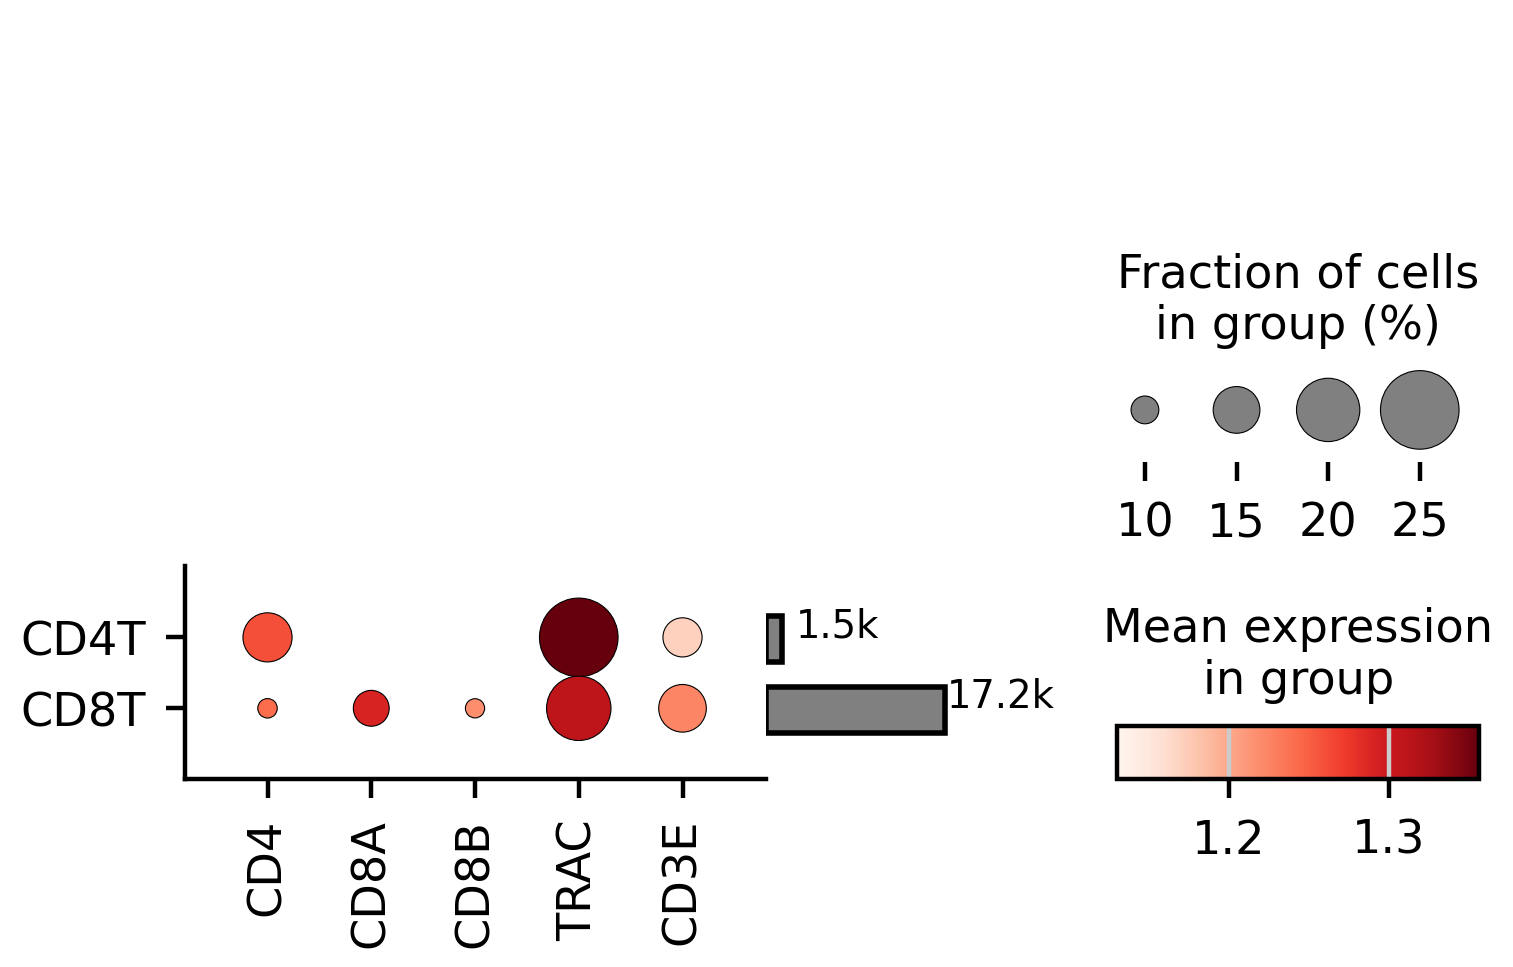

In [12]:
sc.settings.set_figure_params(dpi=200,fontsize=10)
dp = sc.pl.dotplot(tcells,['CD4','CD8A','CD8B','TRAC','CD3E'],groupby='Celltype',mean_only_expressed=True,return_fig=True)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap='Reds',dot_max=.25,dot_min=.05)
dp.show()

# CD8 T cells

In [13]:
adata = sc.read(f'{WORKFLOW_DATA}/{GEX_Cohort}/gex_qc.h5ad')
adata = adata[adata.obs.index.isin(obs.index[obs.Celltype=='CD8T']),:]
for c in ['Cellstate','BestResponse','Patient','Timepoint','Sample_Short','Treatment_Arm','RCB']:
    adata.obs[c] = obs.loc[adata.obs.index,c]
print(f'{adata.obs.shape[0]:,} CD8 T cells')

17,230 CD8 T cells


# Signature scoring

In [14]:
oliveira_sig = (pd.read_excel(f"{EXTERNAL_DATA}/Oliveira_Giacomo_et_al-2021-Nature.xlsx",
                                sheet_name='Supplementary Table 8',
                               skiprows=3).
                   loc[:,:'TTE'].
                   dropna(axis=1,how='all').
                   replace('C16orf45','BMERB1'). # name conversion
                   replace('RARRES3','PLAAT4').
                   replace('SEPT7','SEPTIN7')
                  )
ext_sig_gmt_path =f'{EXTERNAL_DATA}/Oliveira_Giacomo_et_al-2021-Nature.gmt'
with open(ext_sig_gmt_path,'w') as f:
    for c in oliveira_sig:
        f.write('\t'.join([c,'Oliveira_Giacomo_et_al-2021']+oliveira_sig[c].dropna().tolist())+'\n')
    

In [16]:
mp_result = sp.ext.VISION(data=adata,gmt_files=[ext_sig_gmt_path],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ../../data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt --h5ad /tmp/tmpcqpyln84/count.h5ad --output_file /tmp/tmpcqpyln84/vision.tsv
$gmt_files
[1] "../../data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt"

$h5ad
[1] "/tmp/tmpcqpyln84/count.h5ad"

$output_file
[1] "/tmp/tmpcqpyln84/vision.tsv"



Loading data from ../../data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt ...

Using 21107/36601 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...

Warning messages:
1: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 4.7 GiB
2: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 4.7 GiB


In [18]:
mp_result['Cellstate'] = adata.obs['Cellstate']

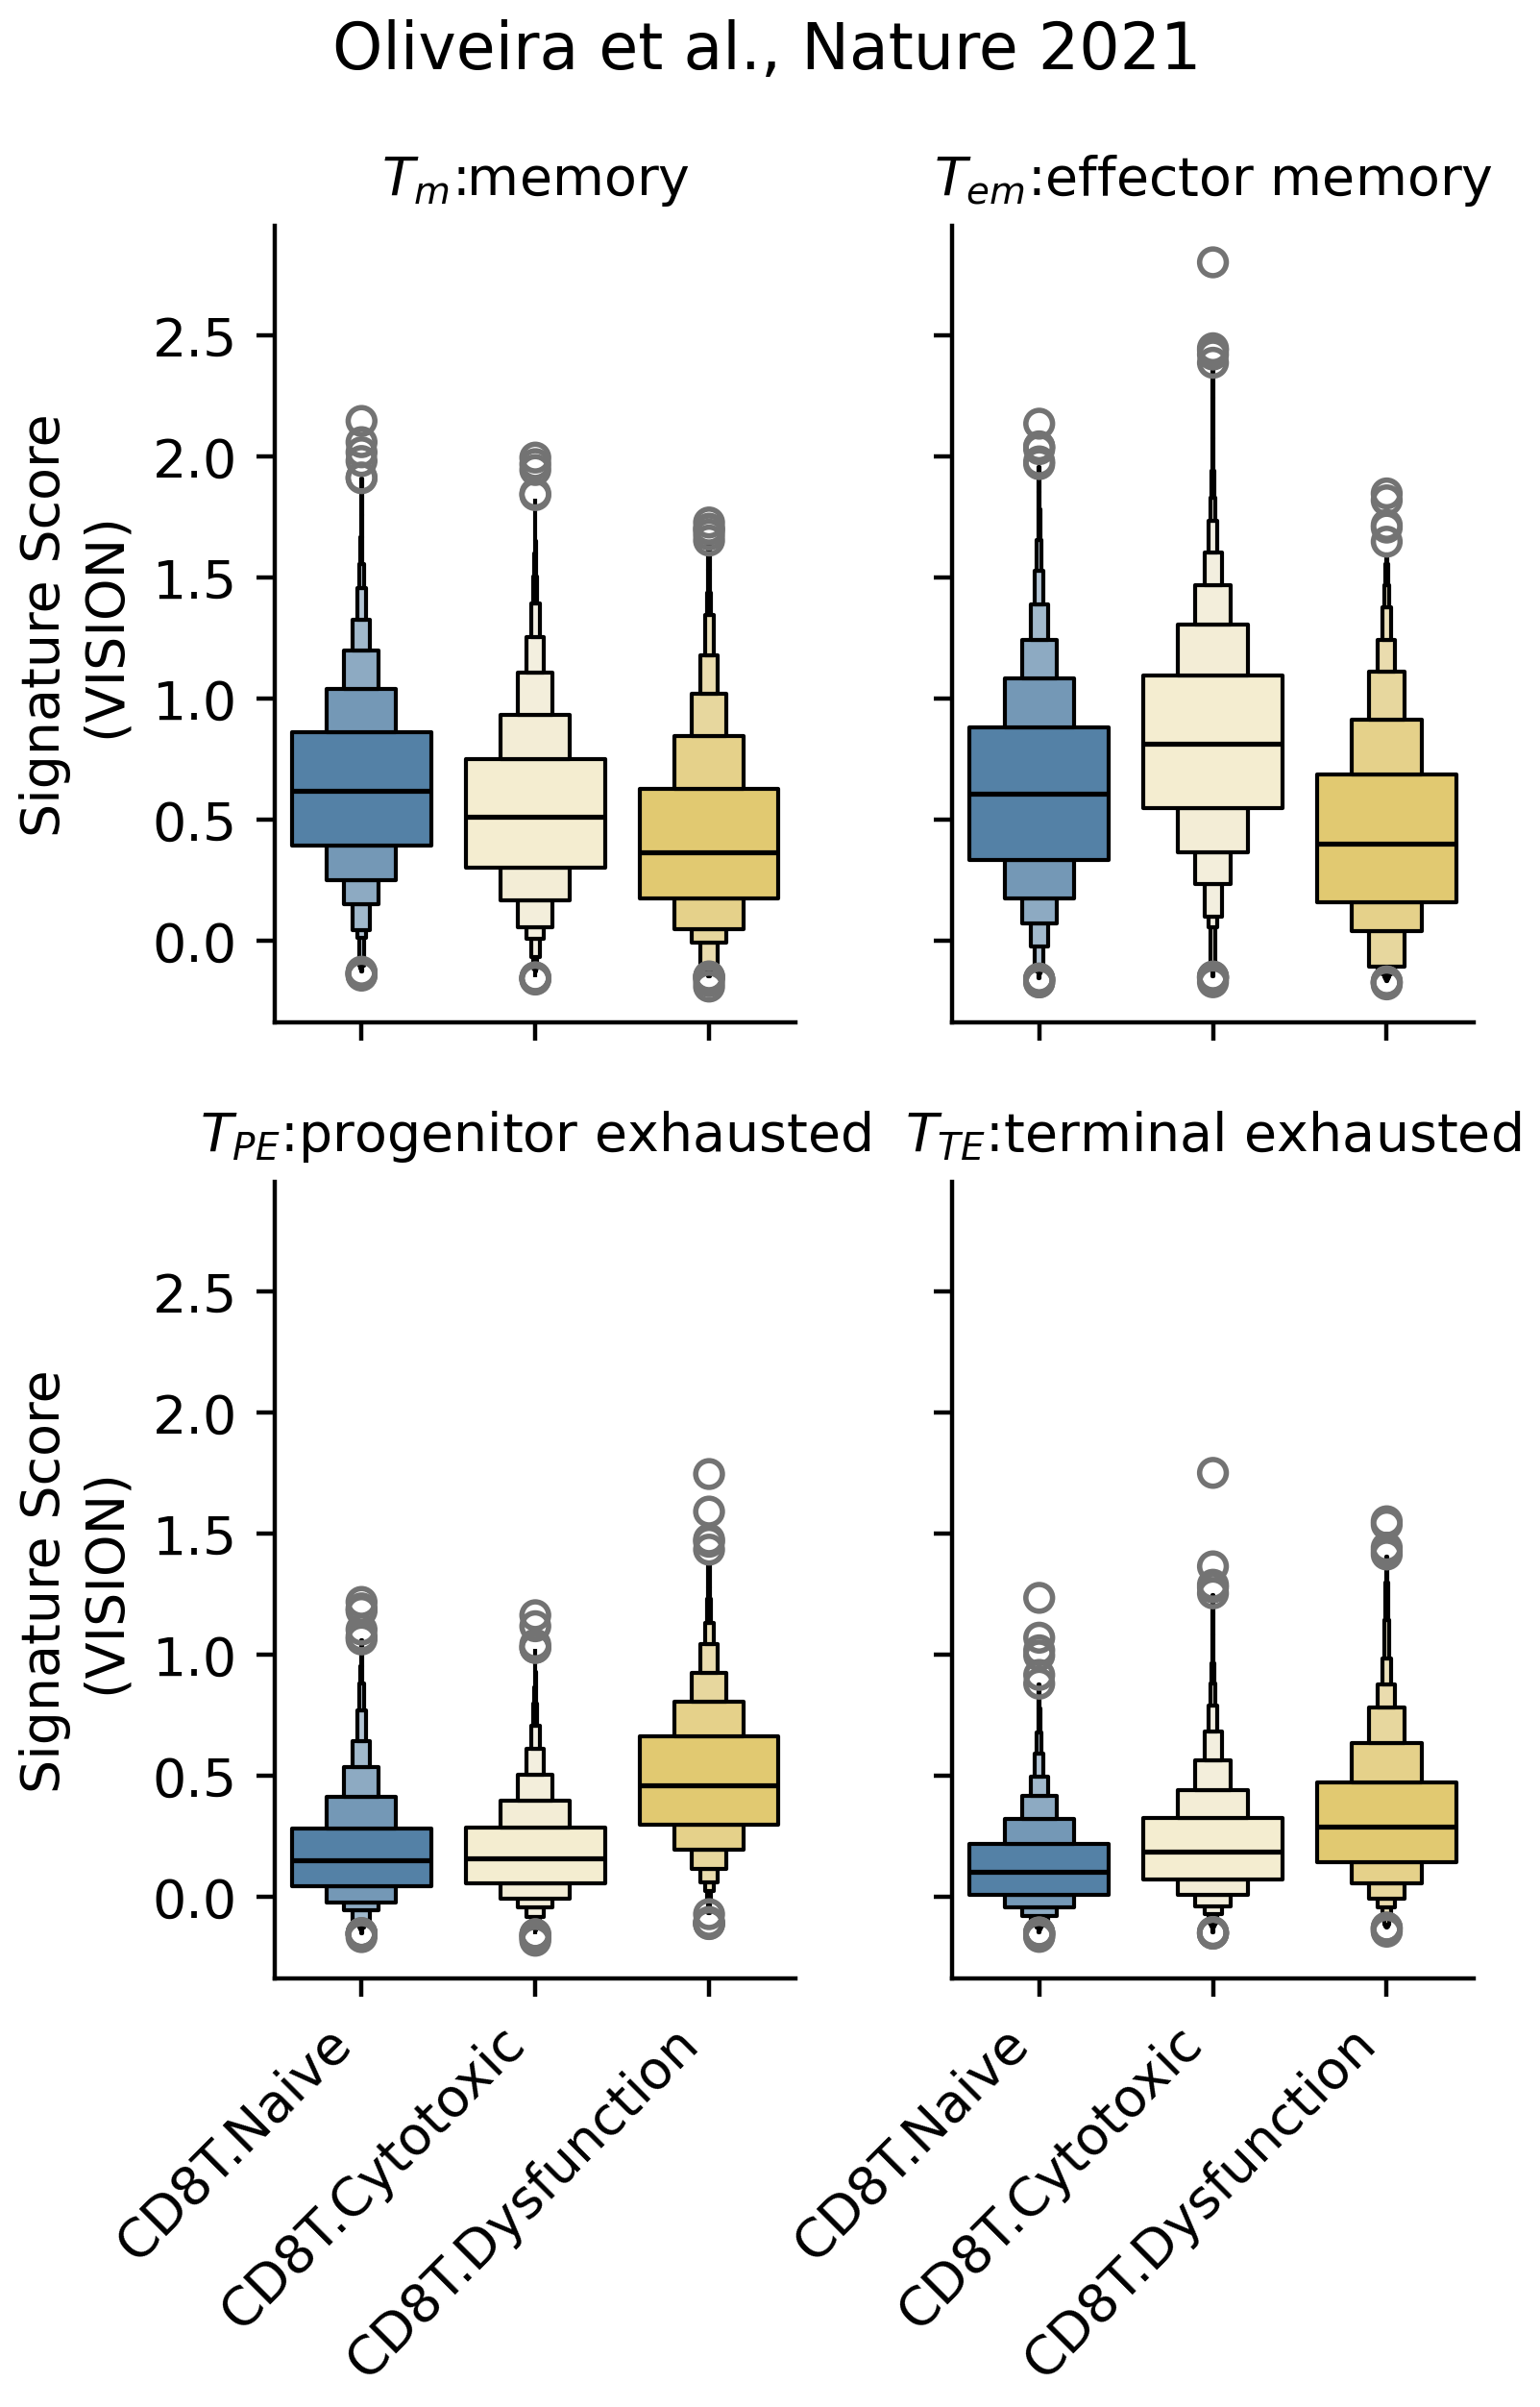

In [80]:
fig,axs = plt.subplots(2,2,sharey=True,sharex=True,dpi=200,figsize=(4,6))

ax=axs[0,0]
y='TM'
sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],palette=COLOR_PAlETTE['Cellstate'],
                  ax=ax)
ax.set(ylabel='Signature Score\n(VISION)',title=r'$T_m$:memory',xlabel='')
ax.grid(False)

ax=axs[0,1]
y='TEM'
sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],palette=COLOR_PAlETTE['Cellstate'],
                  ax=ax)
ax.set(ylabel='Signature Score\n(VISION)',title=r'$T_{em}$:effector memory',xlabel='')
ax.grid(False)

ax=axs[1,0]
y='TPE'
sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],palette=COLOR_PAlETTE['Cellstate'],
                  ax=ax)
ax.set(ylabel='Signature Score\n(VISION)',title=r'$T_{PE}$:progenitor exhausted',xlabel='')
ax.grid(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax=axs[1,1]
y='TTE'
sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],palette=COLOR_PAlETTE['Cellstate'],
                  ax=ax)
ax.set(ylabel='Signature Score\n(VISION)',title=r'$T_{TE}$:terminal exhausted',xlabel='')
ax.grid(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('Oliveira et al., Nature 2021',y=1);
plt.subplots_adjust(hspace=0.2,wspace=.3)

# GEX log1p Normalization

In [81]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)
sp.utils.log1pNorm(adata)

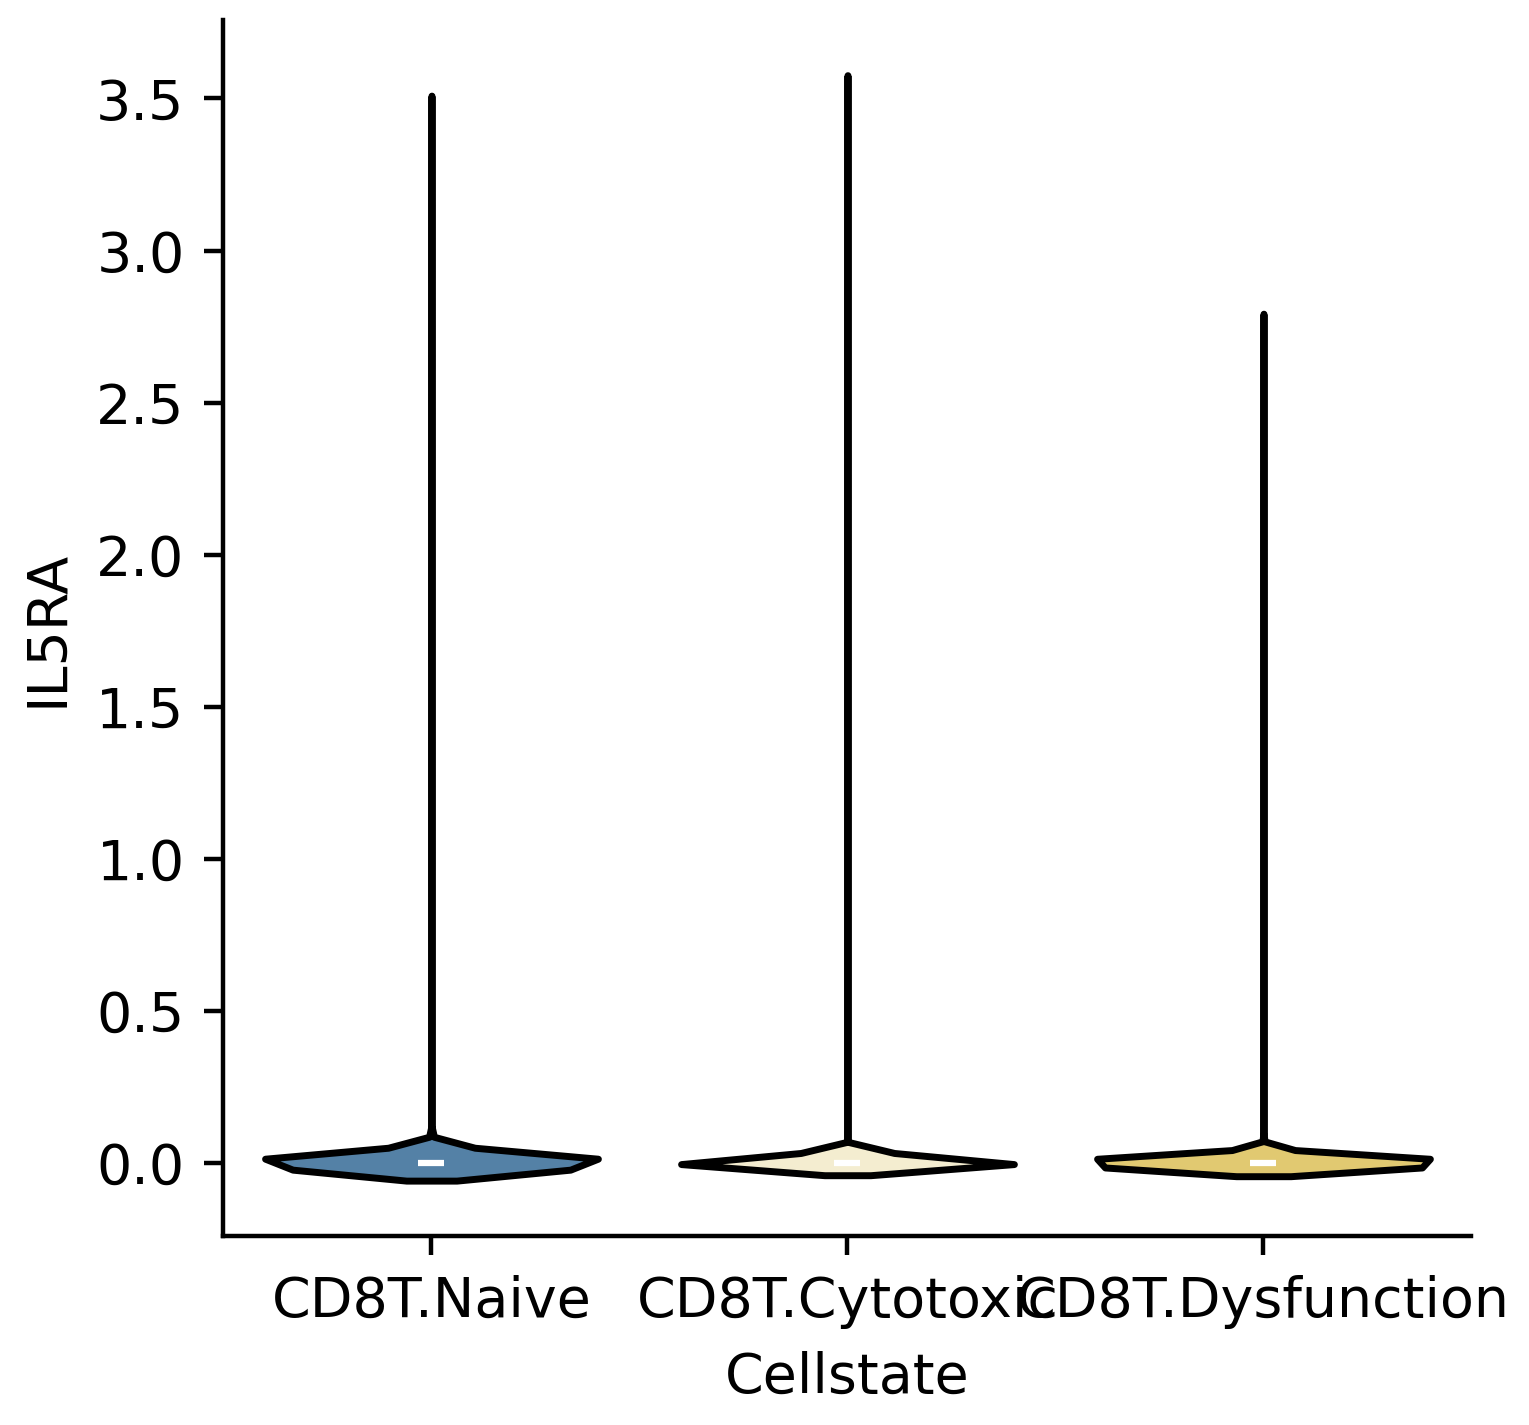

In [98]:
y='IL5RA'
data = sc.get.obs_df(adata,['Cellstate',y])
ax = sns.violinplot(data=data,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],
               palette=COLOR_PAlETTE['Cellstate'])
ax.grid(False)

# Heatmap visualization on genes in each MPs

## Load DEGs

In [10]:
# degs_dict = {}
# for cellstate in adata.obs.Cellstate.unique():
#     degs_dict[cellstate] = pd.read_excel(degs_path,sheet_name=cellstate)

## Load MPs geneset

In [11]:
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

## Visualize MPs in heatmap

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 72.61716666666668 mm


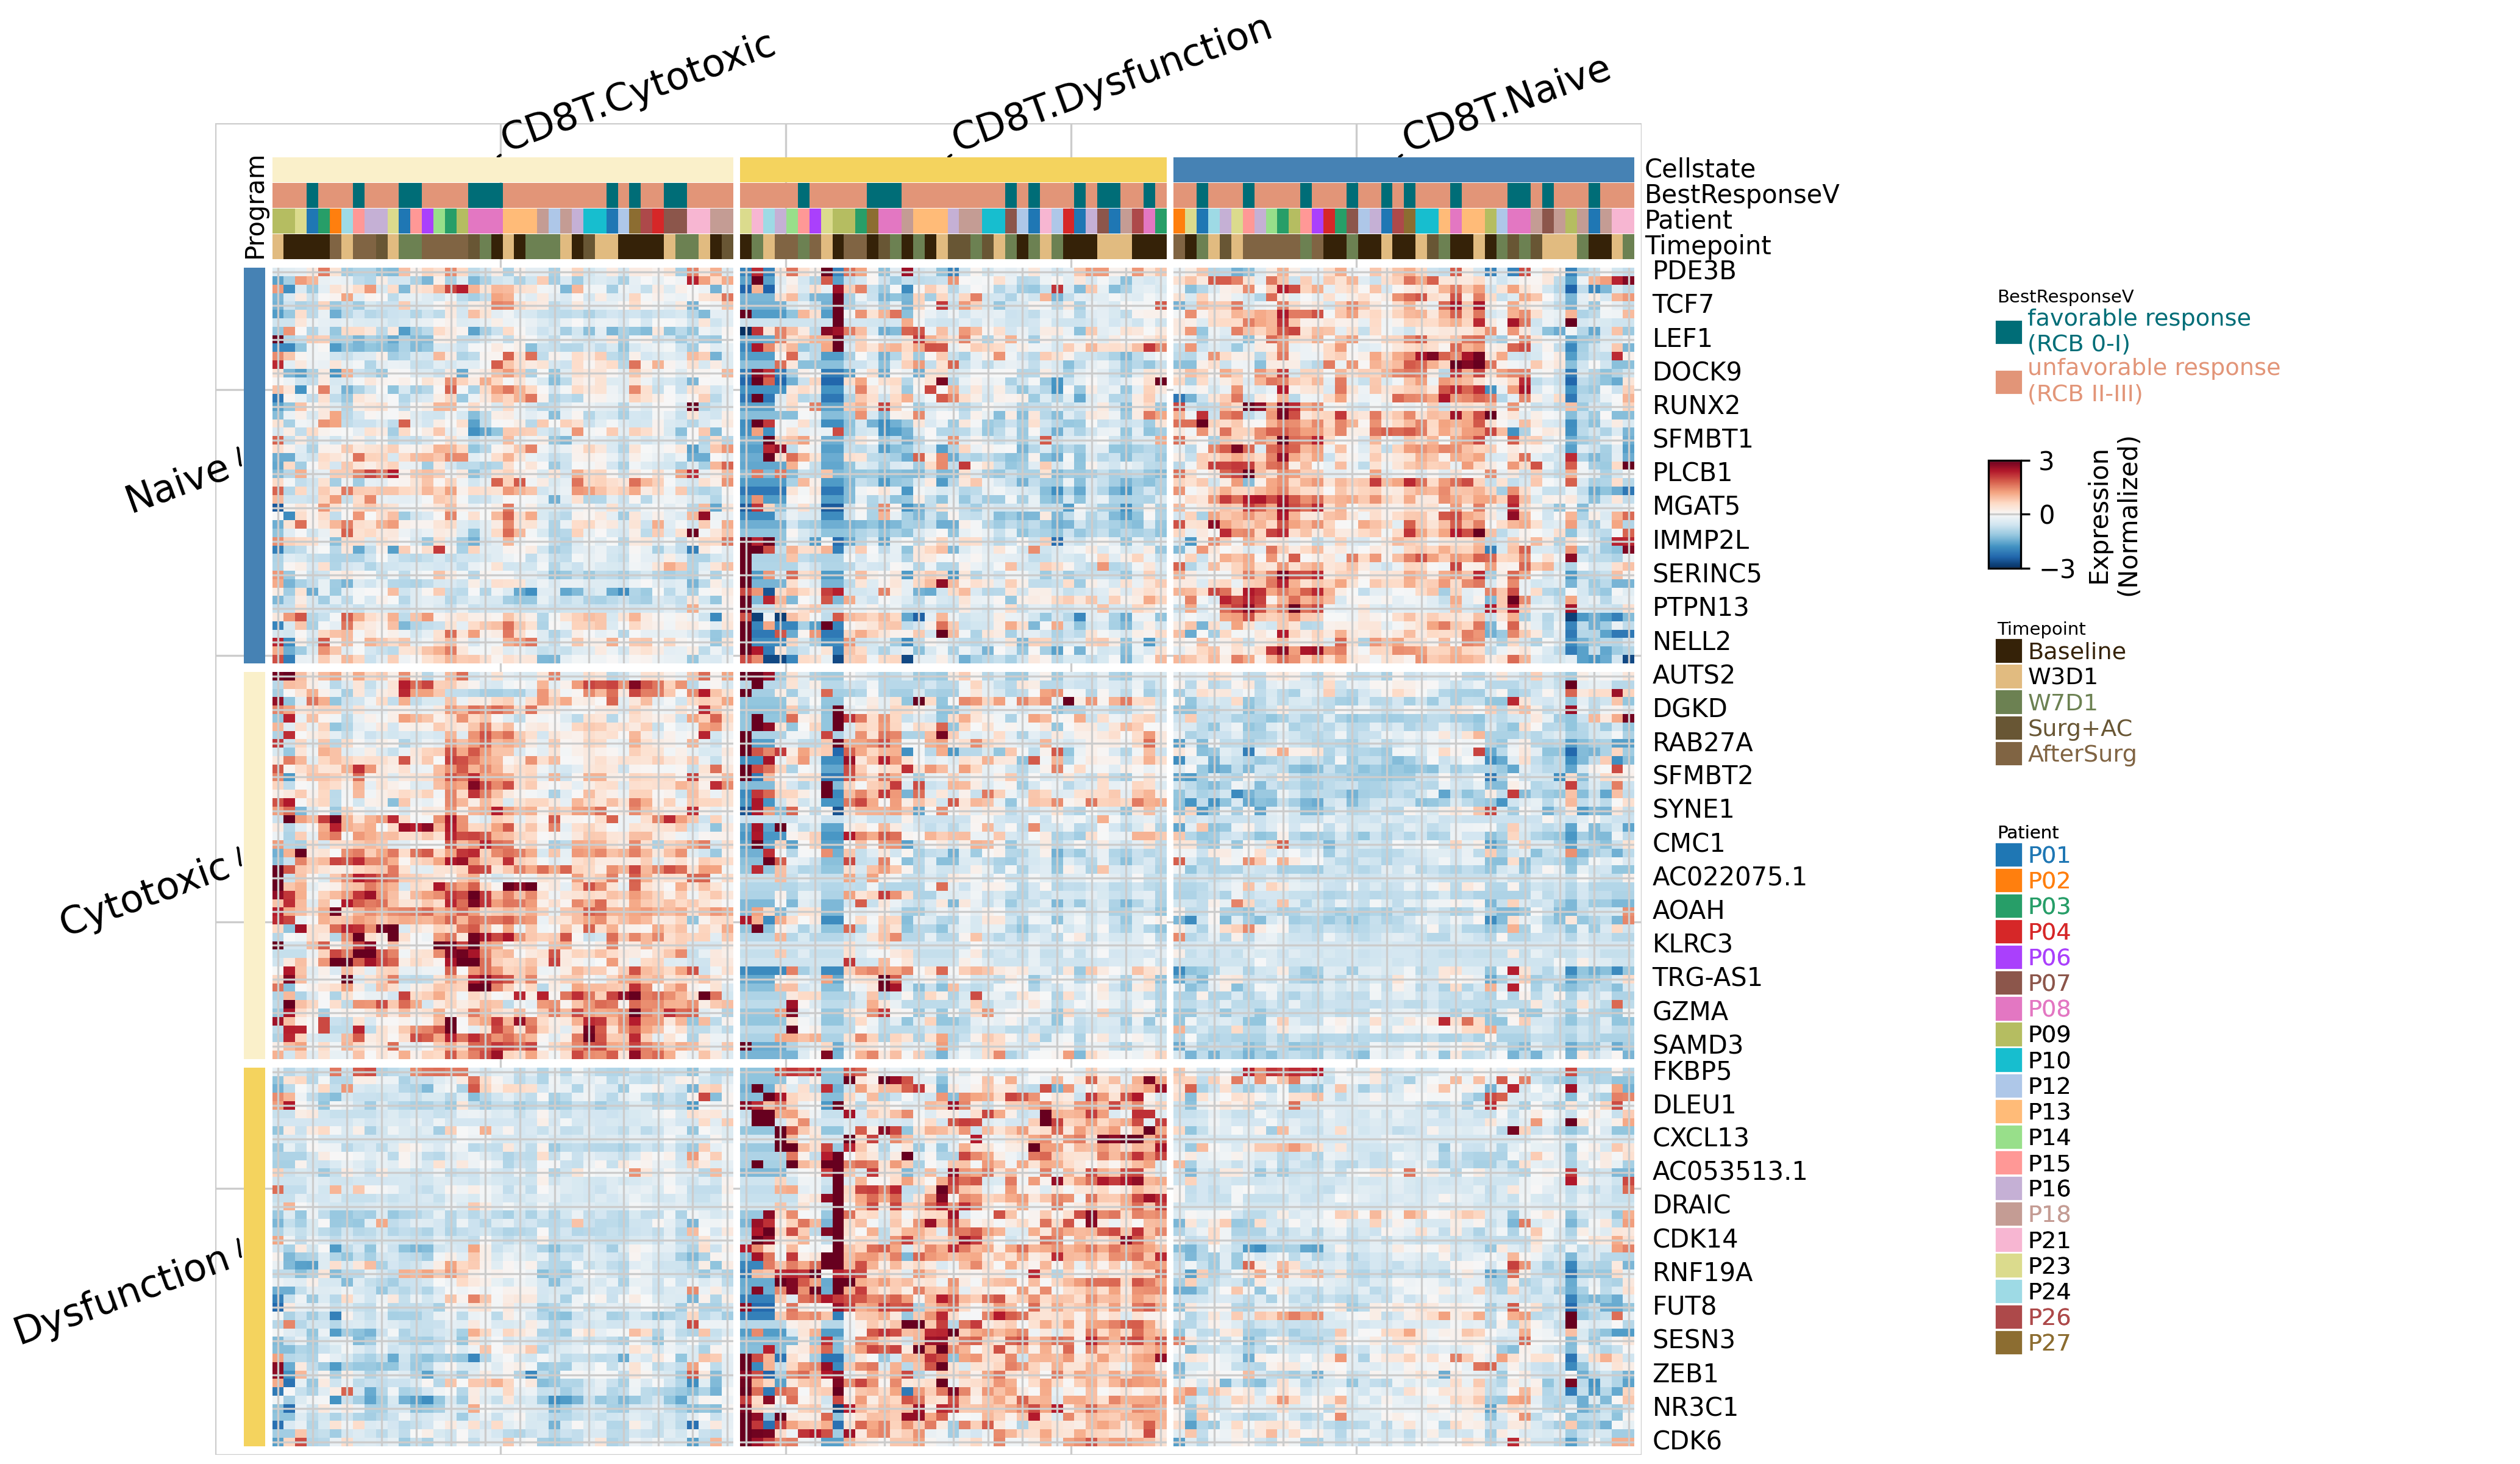

In [12]:
CELLTYPE='CD8T'
palette={}
palette['Program'] = {k.replace(f'{CELLTYPE}.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if CELLTYPE in k}
for c in ['BestResponseV','Patient','Timepoint','Cellstate']:
    palette[c] = COLOR_PAlETTE[c.replace('V','')]
adata.obs['BestResponseV'] = adata.obs.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
aggregate_heatmap(adata=adata,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','BestResponseV','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(10,8),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 72.61716666666668 mm


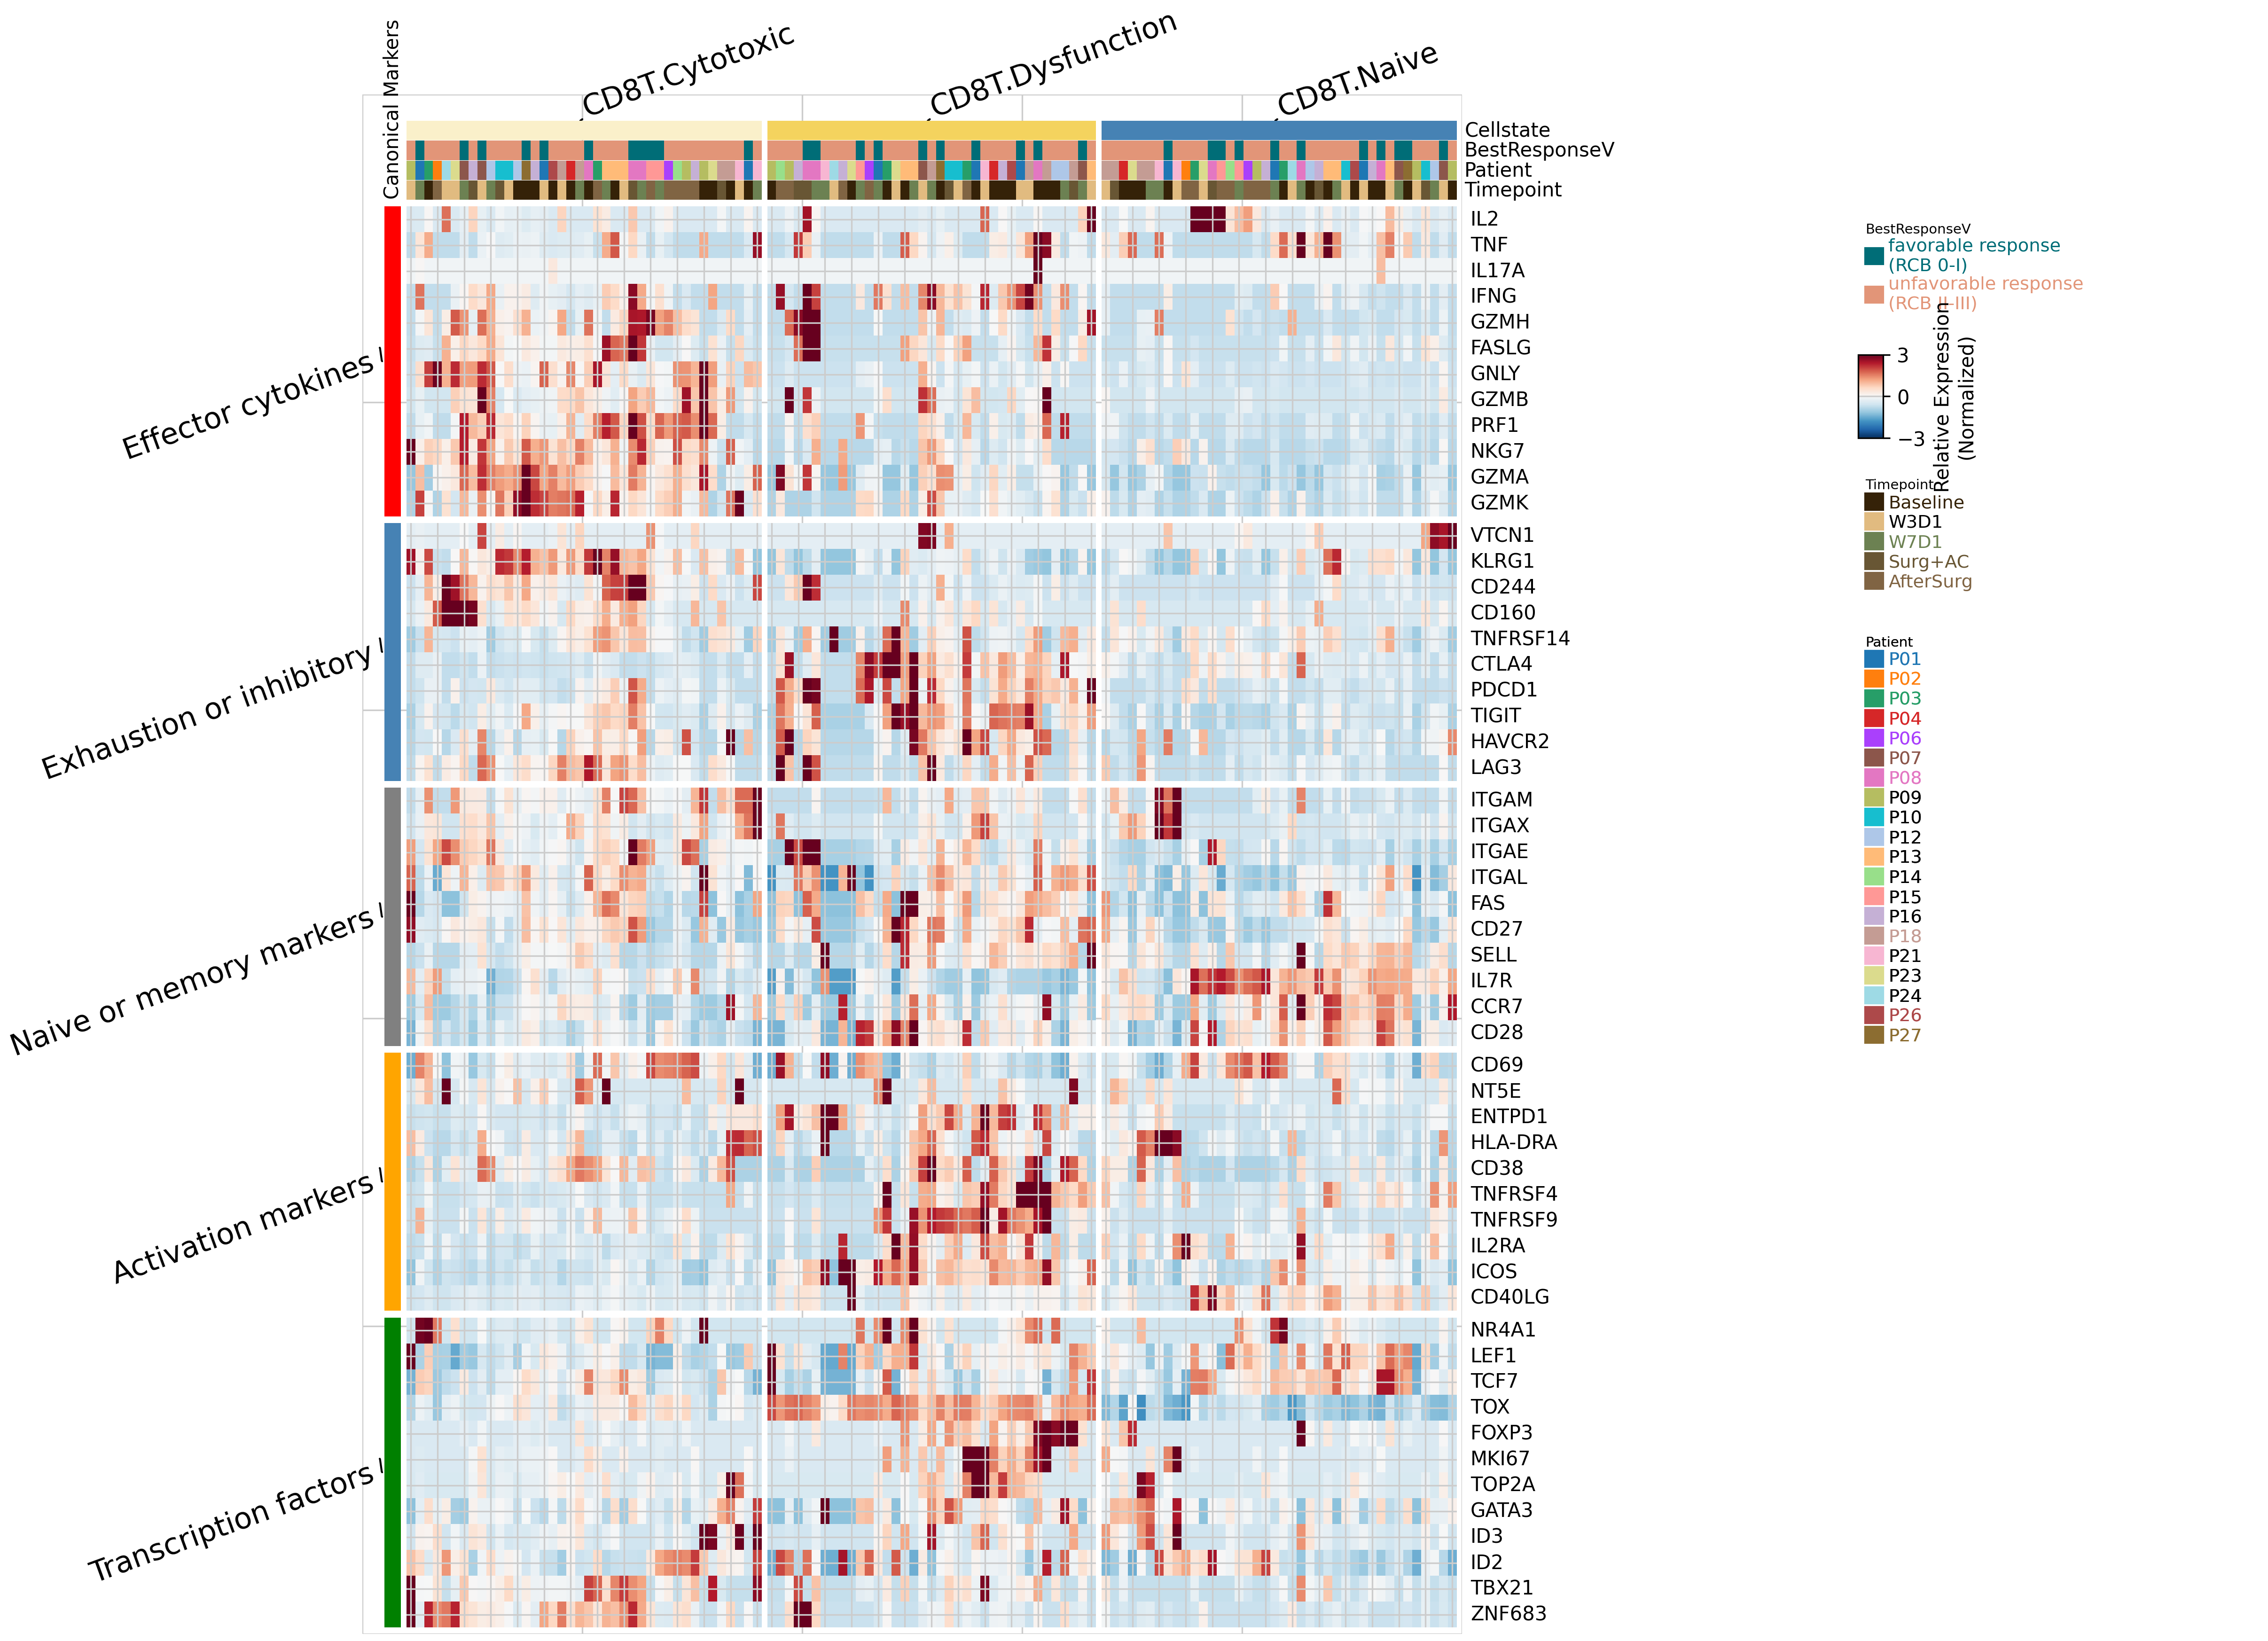

In [13]:
cd8T_custom_markers = {
    'Naive or memory markers':['CCR7','SELL','IL7R','CD28','FAS','CD27','ITGAE','ITGAL','ITGAM','ITGAX'],
    'Exhaustion or inhibitory':['PDCD1','TIGIT','HAVCR2','LAG3','CTLA4','VTCN1','CD244','KLRG1','TNFRSF14','CD160'], #'BLTA'
    'Activation markers':['CD38','ENTPD1','NT5E','CD69','IL2RA','ICOS','TNFRSF4','TNFRSF9','HLA-DRA','CD40LG'],
    'Effector cytokines':['GZMA','GZMB','GZMH','GZMK','PRF1','NKG7','GNLY','IFNG','FASLG','TNF','IL17A','IL2'],
    'Transcription factors':['LEF1','TCF7','TBX21','TOX','GATA3','ID2','ID3','NR4A1','ZNF683','FOXP3','MKI67','TOP2A'],#'EMOES','PRMD1'
}
marker_df = []
for k,v_list in cd8T_custom_markers.items():
    for v in v_list:
        marker_df.append(
            pd.Series({v:k},name='Canonical Markers')
        )
    
marker_df = pd.concat(marker_df).to_frame()
palette['Canonical Markers']={
    'Naive or memory markers':'gray',
    'Exhaustion or inhibitory':'steelblue', 
    'Activation markers':'orange',
    'Effector cytokines':'red',
    'Transcription factors':'green',
    'NK/gamma-delta T cell genes':'salmon'
}
aggregate_heatmap(adata=adata,
                  features=marker_df,
                  top_anno_columns=['Cellstate','BestResponseV','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Canonical Markers',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(10,12),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Relative Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )

# Score association

In [14]:
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(score_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
scores = scores[scores.columns[scores.columns.str.endswith(signature_method)]]
scores.columns = scores.columns.map(lambda x:x.split('_')[0])#.map(MP_anno_map)

obs = adata.obs.loc[scores.index,:]
# attach clinical information
scores = scores.merge(obs,left_index=True,right_index=True)

## Dimension reduction for representing the scoring

In [15]:
for x in ['MP3', 'MP1', 'MP4']:
    adata.obs[MP_anno_map[x]]= scores[x]

In [16]:
import scanpy.external as sce

In [17]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)
sp.utils.log1pNorm(adata)
adata.layers['norm'] = adata.X.copy()
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, use_highly_variable=True)
sce.pp.harmony_integrate(adata, 'Sample_Short')
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')
adata.X = adata.layers['norm'].copy()
del adata.layers['norm'] 

2024-07-02 19:21:20,799 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-07-02 19:21:27,276 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-02 19:21:27,489 - harmonypy - INFO - Iteration 1 of 10
2024-07-02 19:21:36,108 - harmonypy - INFO - Iteration 2 of 10
2024-07-02 19:21:44,630 - harmonypy - INFO - Iteration 3 of 10
2024-07-02 19:21:53,238 - harmonypy - INFO - Iteration 4 of 10
2024-07-02 19:21:58,222 - harmonypy - INFO - Iteration 5 of 10
2024-07-02 19:22:02,533 - harmonypy - INFO - Iteration 6 of 10
2024-07-02 19:22:06,848 - harmonypy - INFO - Iteration 7 of 10
2024-07-02 19:22:10,773 - harmonypy - INFO - Iteration 8 of 10
2024-07-02 19:22:14,665 - harmonypy - INFO - Iteration 9 of 10
2024-07-02 19:22:18,748 - harmonypy - INFO - Converged after 9 iterations


In [8]:
sc.tl.umap(adata,min_dist=.1,spread=1)

In [13]:
sc.settings.set_figure_params(dpi=150)

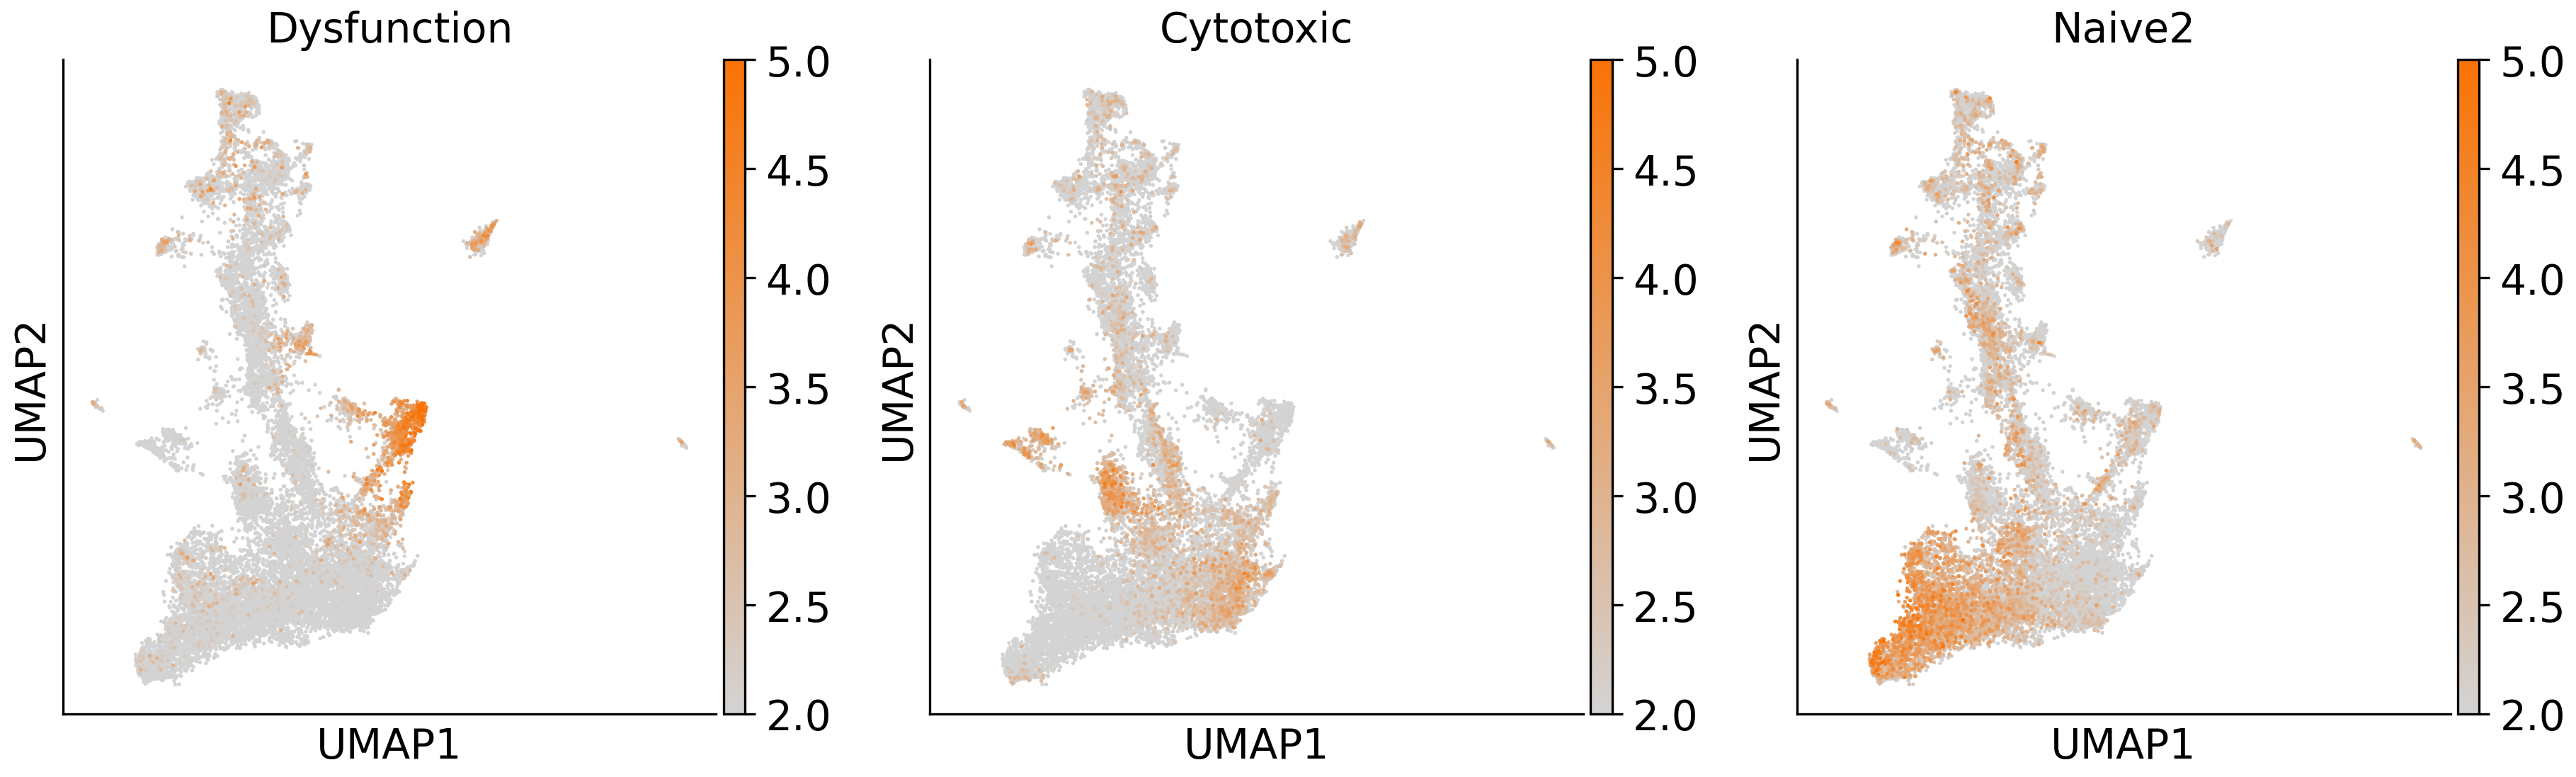

In [17]:
sc.pl.umap(adata,color=list(MP_anno_map.values()),
          cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["orange"]], as_cmap=True),ncols=3,
          legend_loc='on data',vmin=2,vmax=5)

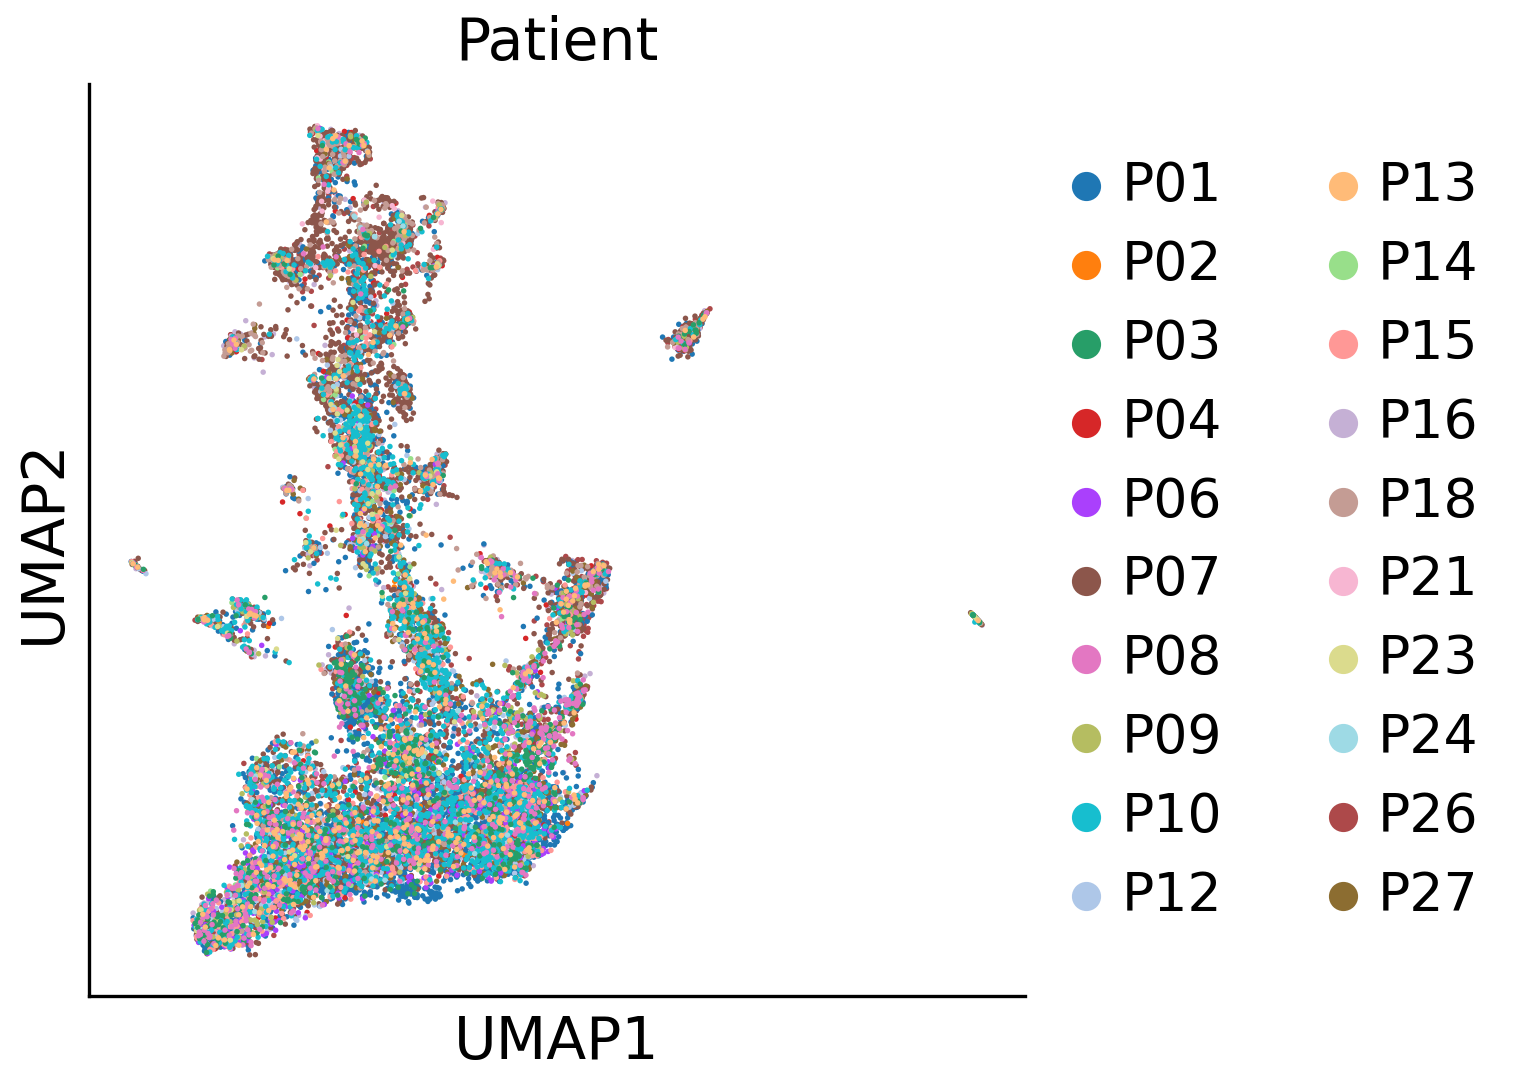

In [18]:
sc.pl.umap(adata,color=['Patient'])

# C3D1 prediction power

In [18]:
x='BestResponse'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['W3D1']),:].copy()
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

BestResponse Treatment_Arm  N_Pts
0          0-I    Chemo->ICI      2
1       II-III    Chemo->ICI      3
2       II-III    ICI->Chemo      4

In [19]:
dt[x] = pd.Categorical(dt[x],['0-I','II-III'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

Ctrl Experiment            Y      Coef    log2FC              Pvalue  \
0  0-I     II-III  Dysfunction  0.040904 -0.049924  0.8075982062134412   
0  0-I     II-III    Cytotoxic -0.014611  0.159458  0.9318563595946002   
0  0-I     II-III        Naive  0.261628  0.299128  0.5022177408389252   

        FDR  
0  0.931856  
0  0.931856  
0  0.931856

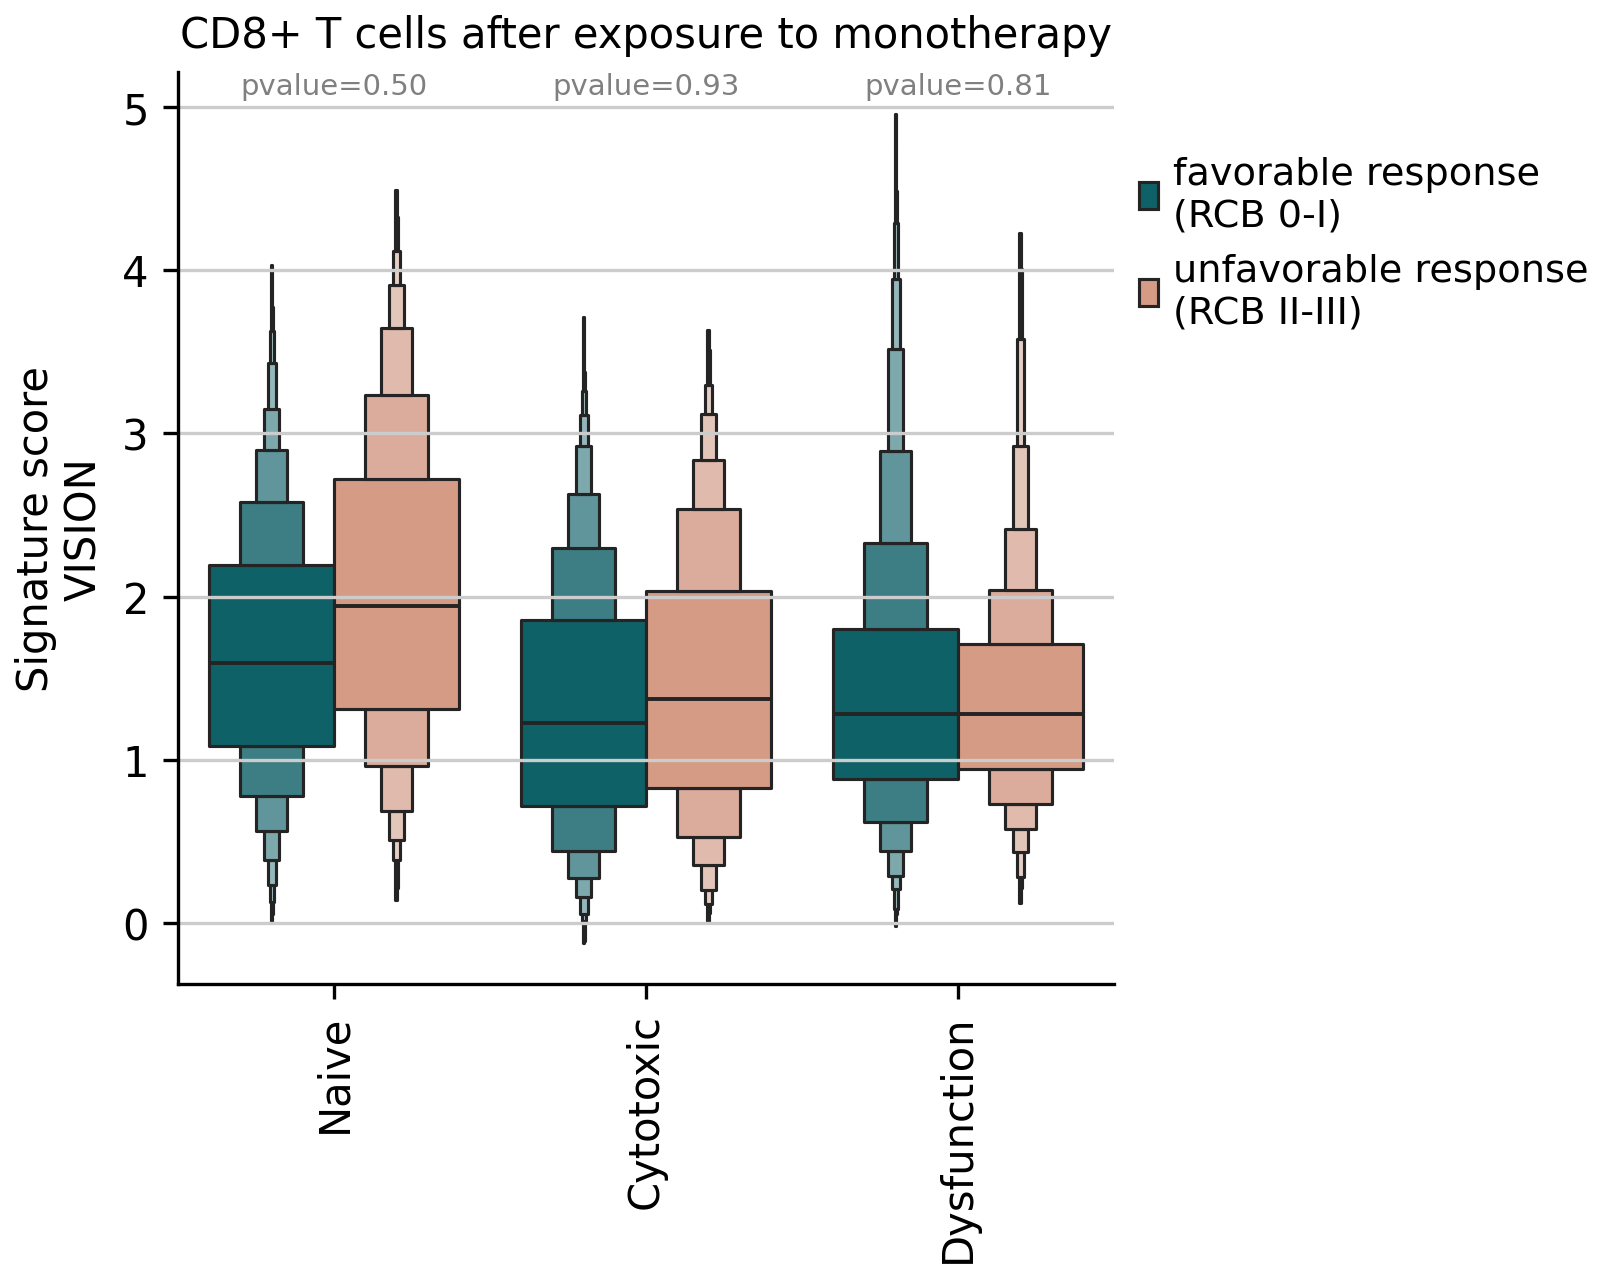

In [20]:
show_mps = ['Naive','Cytotoxic','Dysfunction']
dt.rename(columns=MP_anno_map,inplace=True)
pvalues = result.loc[result.Y.isin(show_mps),:].set_index('Y')['Pvalue']
fig,ax=plt.subplots(1,1,dpi=150)
dt.BestResponse= dt.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                   ax=ax,
                x='variable',y='value',hue=x,
                   showfliers=False,
#                 split=True,inner="quart", fill=False,
                palette=COLOR_PAlETTE[x])
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = f"pvalue={pvalues[text]:.2f}"
    else:
        label = f"pvalue={pvalues[text]:.3f}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
ax.tick_params(axis='x',rotation=90)
n_pt_label = ','.join([ f"N({k})={v}"for k,v in dt.drop_duplicates([random_var])[x].value_counts().to_dict().items()])
ax.set(xlabel='',ylabel=f'Signature score\n{signature_method}',title=f'CD8+ T cells after exposure to monotherapy')# [{n_pt_label}]')
ax.legend(loc=(1.01,.7),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False)

# Baseline prediction power

In [51]:
x='BestResponse'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline']),:].copy()
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

BestResponse Treatment_Arm  N_Pts
0          0-I    Chemo->ICI      1
1          0-I    ICI->Chemo      2
2       II-III    Chemo->ICI      3
3       II-III    ICI->Chemo      6

In [52]:
dt.groupby(['RCB','Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

RCB Treatment_Arm  N_Pts
0    0    ICI->Chemo      1
1    I    Chemo->ICI      1
2    I    ICI->Chemo      1
3   II    Chemo->ICI      2
4   II    ICI->Chemo      3
5  III    Chemo->ICI      1
6  III    ICI->Chemo      3

In [53]:
dt = dt.loc[dt.Treatment_Arm=='ICI->Chemo',:]
dt[x] = pd.Categorical(dt[x],['0-I','II-III'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

Ctrl Experiment            Y      Coef    log2FC                Pvalue  \
0  0-I     II-III    Cytotoxic -0.512067 -0.589538  0.018468982764248285   
0  0-I     II-III  Dysfunction -0.327612 -0.324347   0.00990350752554793   
0  0-I     II-III        Naive -0.485309 -0.277965   0.13207713472970917   

        FDR  
0  0.027703  
0  0.027703  
0  0.132077

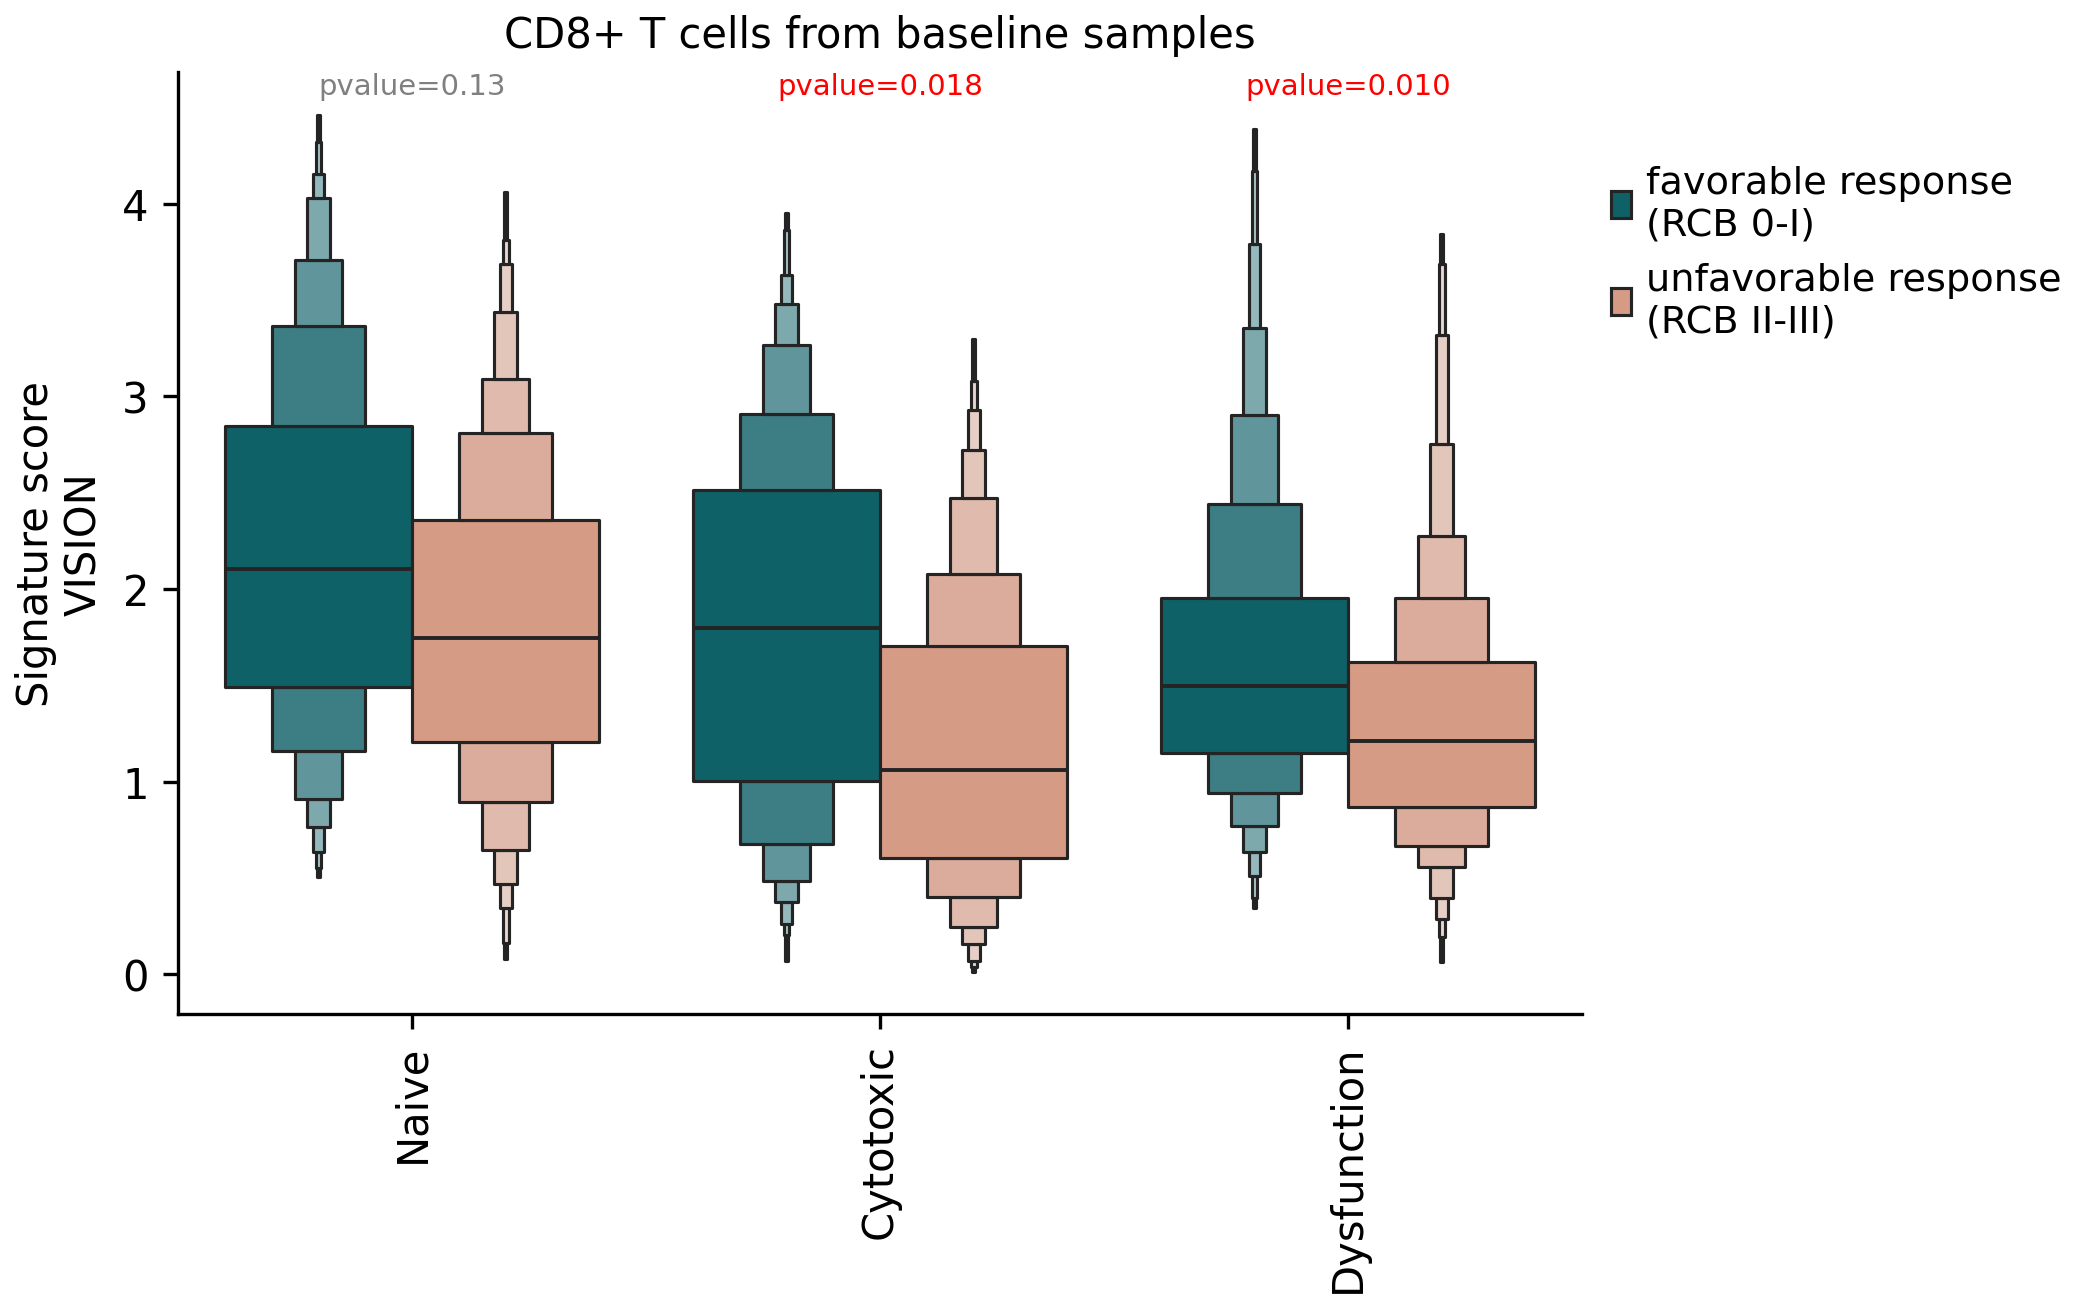

In [54]:
show_mps = ['Naive','Cytotoxic','Dysfunction']
dt.rename(columns=MP_anno_map,inplace=True)
pvalues = result.loc[result.Y.isin(show_mps),:].set_index('Y')['Pvalue']
fig,ax=plt.subplots(1,1,dpi=150)
dt.BestResponse= dt.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                   ax=ax,
                x='variable',y='value',hue=x,
                   showfliers=False,
#                 split=True,inner="quart", fill=False,
                palette=COLOR_PAlETTE[x])
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = f"pvalue={pvalues[text]:.2f}"
    else:
        label = f"pvalue={pvalues[text]:.3f}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
ax.tick_params(axis='x',rotation=90)
n_pt_label = ','.join([ f"N({k})={v}"for k,v in dt.drop_duplicates([random_var])[x].value_counts().to_dict().items()])
ax.set(xlabel='',ylabel=f'Signature score\n{signature_method}',title=f'CD8+ T cells from baseline samples')# [{n_pt_label}]')
ax.legend(loc=(1.01,.7),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False)

# Paired pt from Baselint to W3D1

In [28]:
x='Timepoint'
explored_z='Treatment_Arm'
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W3D1']),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint  N_Pts
0  Baseline      5
1      W3D1      5

In [29]:
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

Ctrl Experiment            Y      Coef    log2FC  \
0  Baseline       W3D1  Dysfunction  0.119629  0.050852   
0  Baseline       W3D1  Dysfunction  0.068039  0.050852   
0  Baseline       W3D1  Dysfunction   0.29754  0.050852   
0  Baseline       W3D1        Naive  0.512249  0.111626   
0  Baseline       W3D1        Naive  0.616703  0.111626   
0  Baseline       W3D1        Naive  0.154276  0.111626   
0  Baseline       W3D1    Cytotoxic  0.438982   0.46074   
0  Baseline       W3D1    Cytotoxic  0.499469   0.46074   
0  Baseline       W3D1    Cytotoxic  0.214083   0.46074   

                   Pvalue          Treatment_Arm       FDR  
0    0.004279905761291051  Chemo->ICI+ICI->Chemo   0.00428  
0      0.1525156661339875             Chemo->ICI  0.152516  
0   0.0012497890454924473             ICI->Chemo   0.00287  
0    2.66981932415343e-39  Chemo->ICI+ICI->Chemo       0.0  
0    1.64732977565972e-44             Chemo->ICI       0.0  
0     0.06151887112210351             ICI->Chemo  0.061519  
0  1.4313492477467955e-27  Chemo->ICI+ICI->Chemo       0.0  
0  4.1007317414749015e-25             Chemo->ICI       0.0  
0    0.001913642884678759             ICI->Chemo   0.00287

# Paired pt timepoint- treatment induced effect

In [21]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1'])&
                (scores.BestResponse=='II-III'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint  N_Pts
0  Baseline      3
1      W7D1      3

In [22]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

Ctrl Experiment            Y      Coef    log2FC                Pvalue  \
0  Baseline       W7D1        Naive -0.134514 -0.259547   0.01612511500163795   
0  Baseline       W7D1  Dysfunction  0.035863 -0.002152   0.43733663114643073   
0  Baseline       W7D1    Cytotoxic  0.119615  0.011066  0.020810133573885715   

        FDR  
0  0.031215  
0  0.437337  
0  0.031215

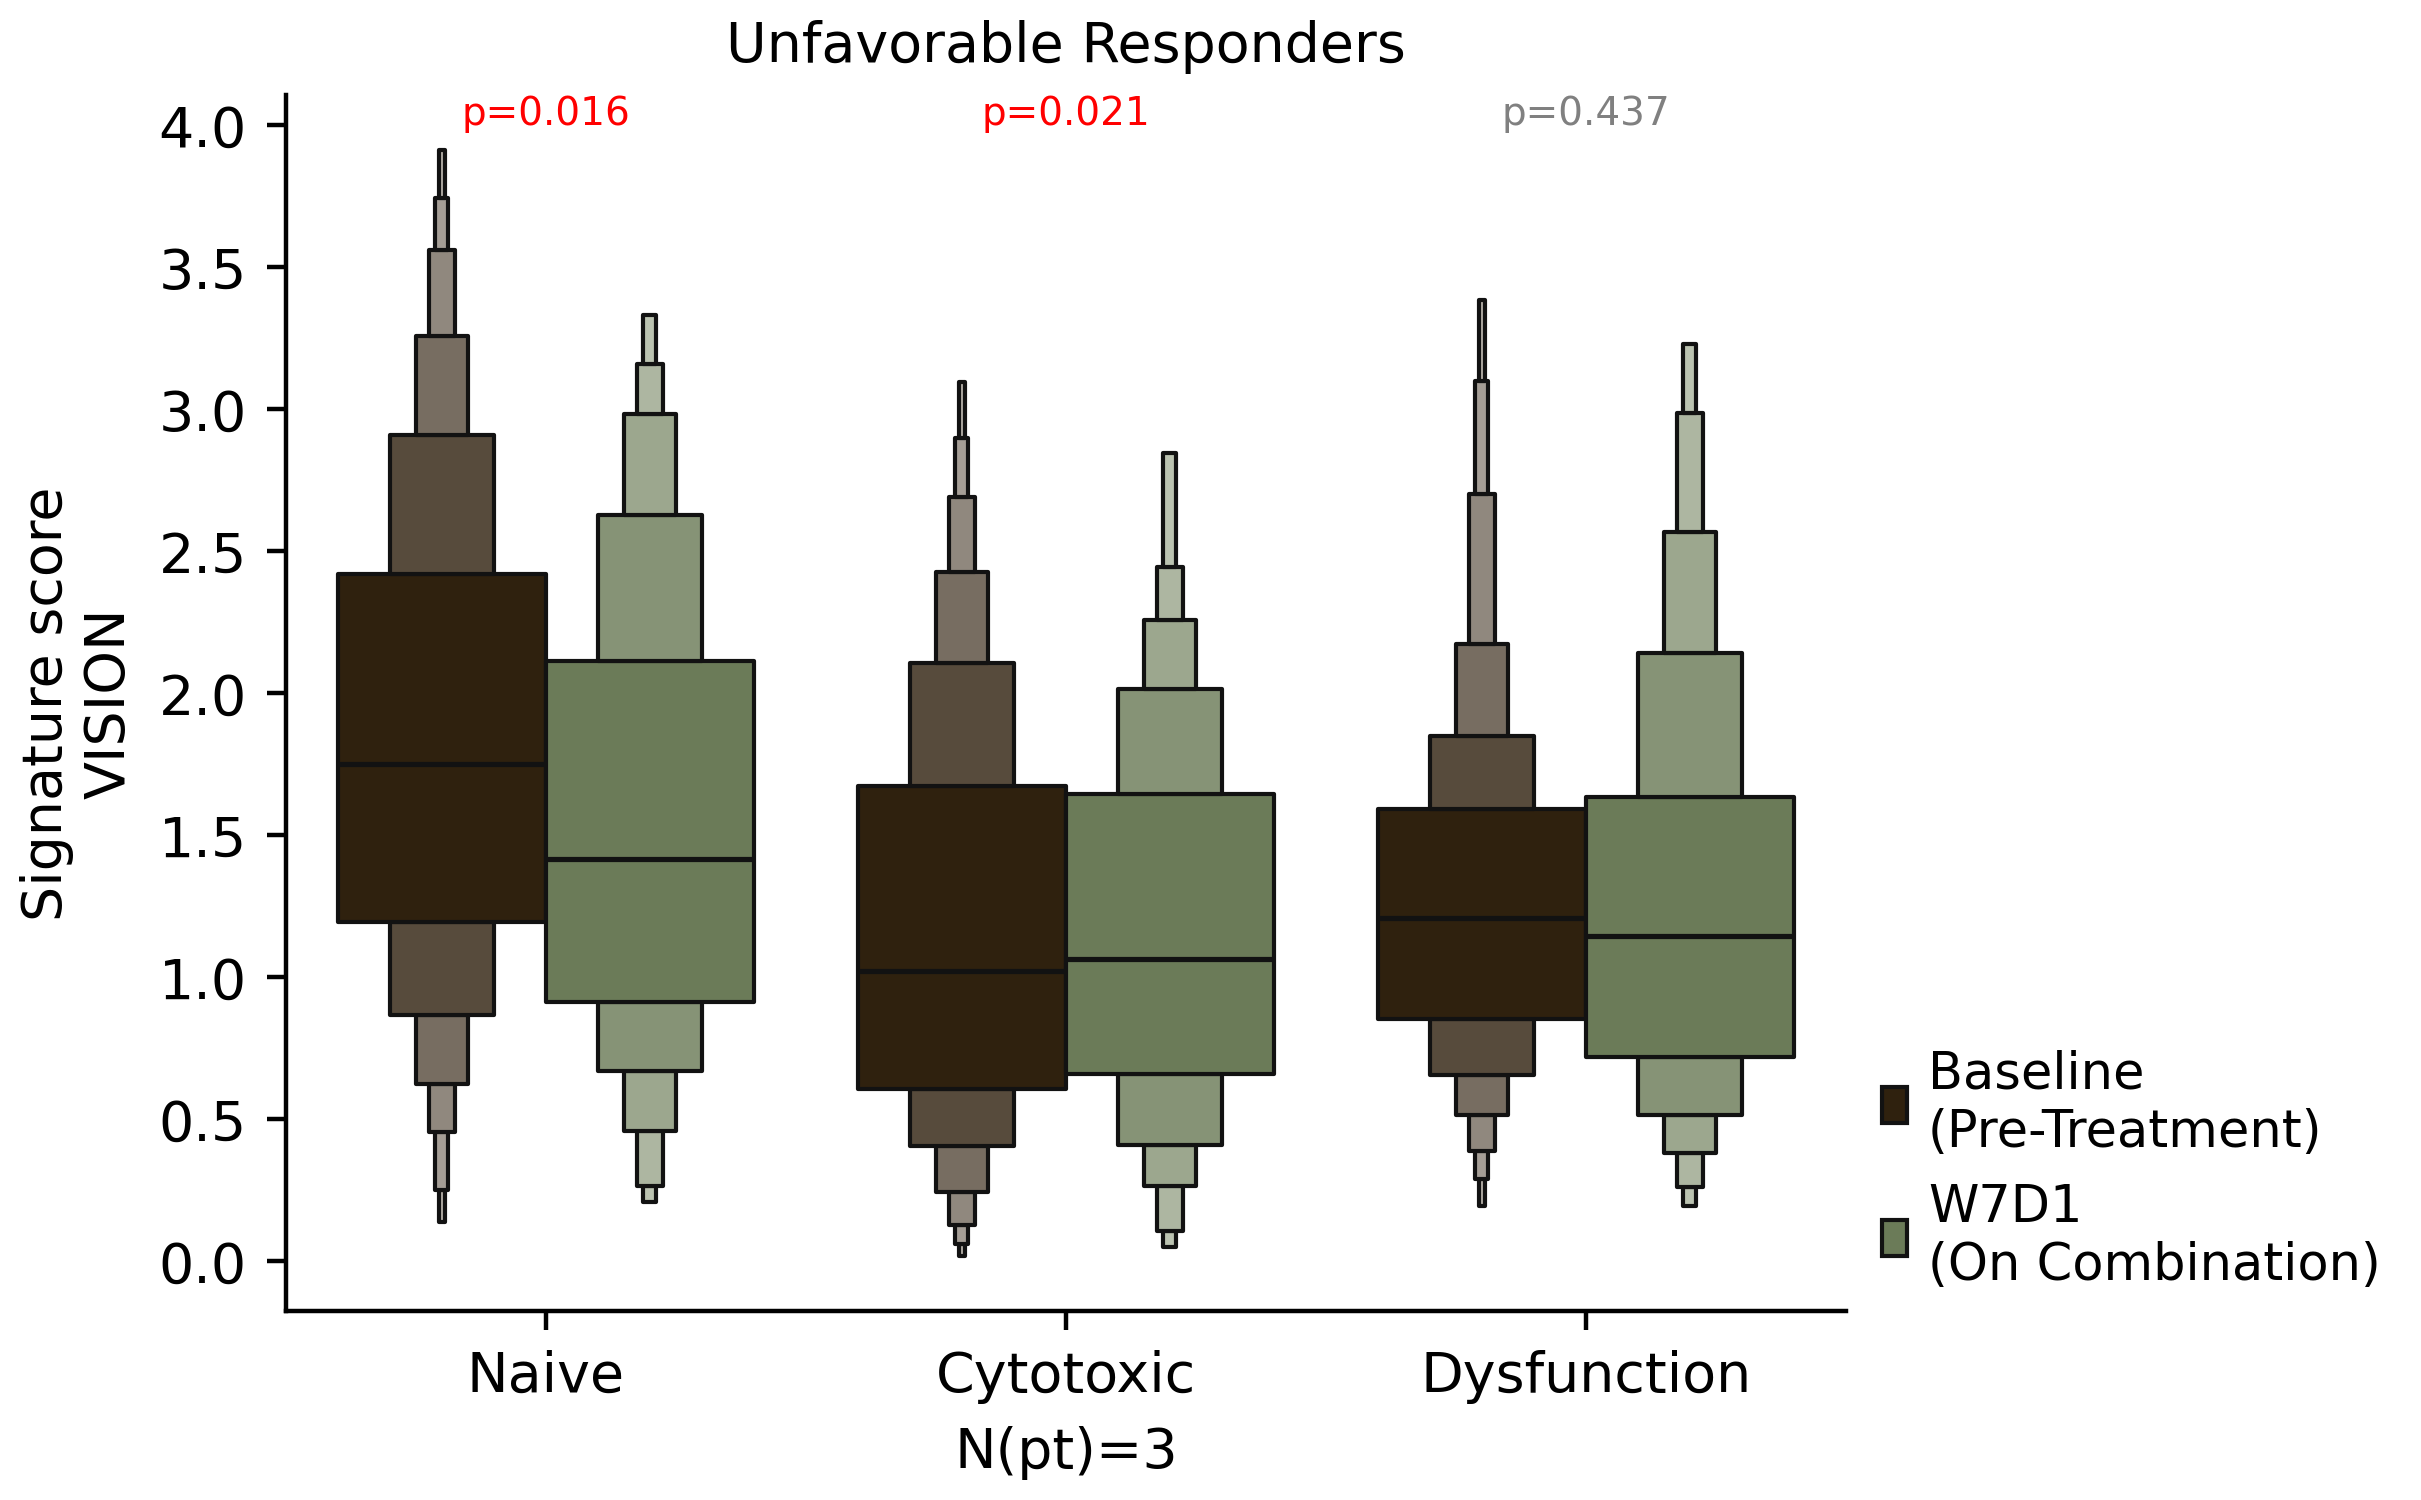

In [26]:
show_mps = ['Naive','Cytotoxic','Dysfunction']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)

plot_rename = {'Baseline':'Baseline\n(Pre-Treatment)','W7D1':'W7D1\n(On Combination)'}
dt[x] = dt[x].replace(plot_rename)
palette = {}
for k,v in plot_rename.items():
    palette[v] = COLOR_PAlETTE[x][k]

fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=200)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=palette,ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.3f}"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='Unfavorable Responders')
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.grid(False)
ax.spines[['right','top']].set_visible(False);

### In Responders

In [27]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1'])&
                (scores.BestResponse=='0-I'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

Timepoint  N_Pts
0  Baseline      2
1      W7D1      2

In [28]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

Ctrl Experiment            Y      Coef    log2FC  \
0  Baseline       W7D1  Dysfunction  0.085533 -0.277752   
0  Baseline       W7D1        Naive  0.117923 -0.195432   
0  Baseline       W7D1    Cytotoxic  0.638251  0.448007   

                  Pvalue       FDR  
0   0.022032742221145547  0.022033  
0  0.0036985793980376103  0.005548  
0  6.391613728342485e-58       0.0

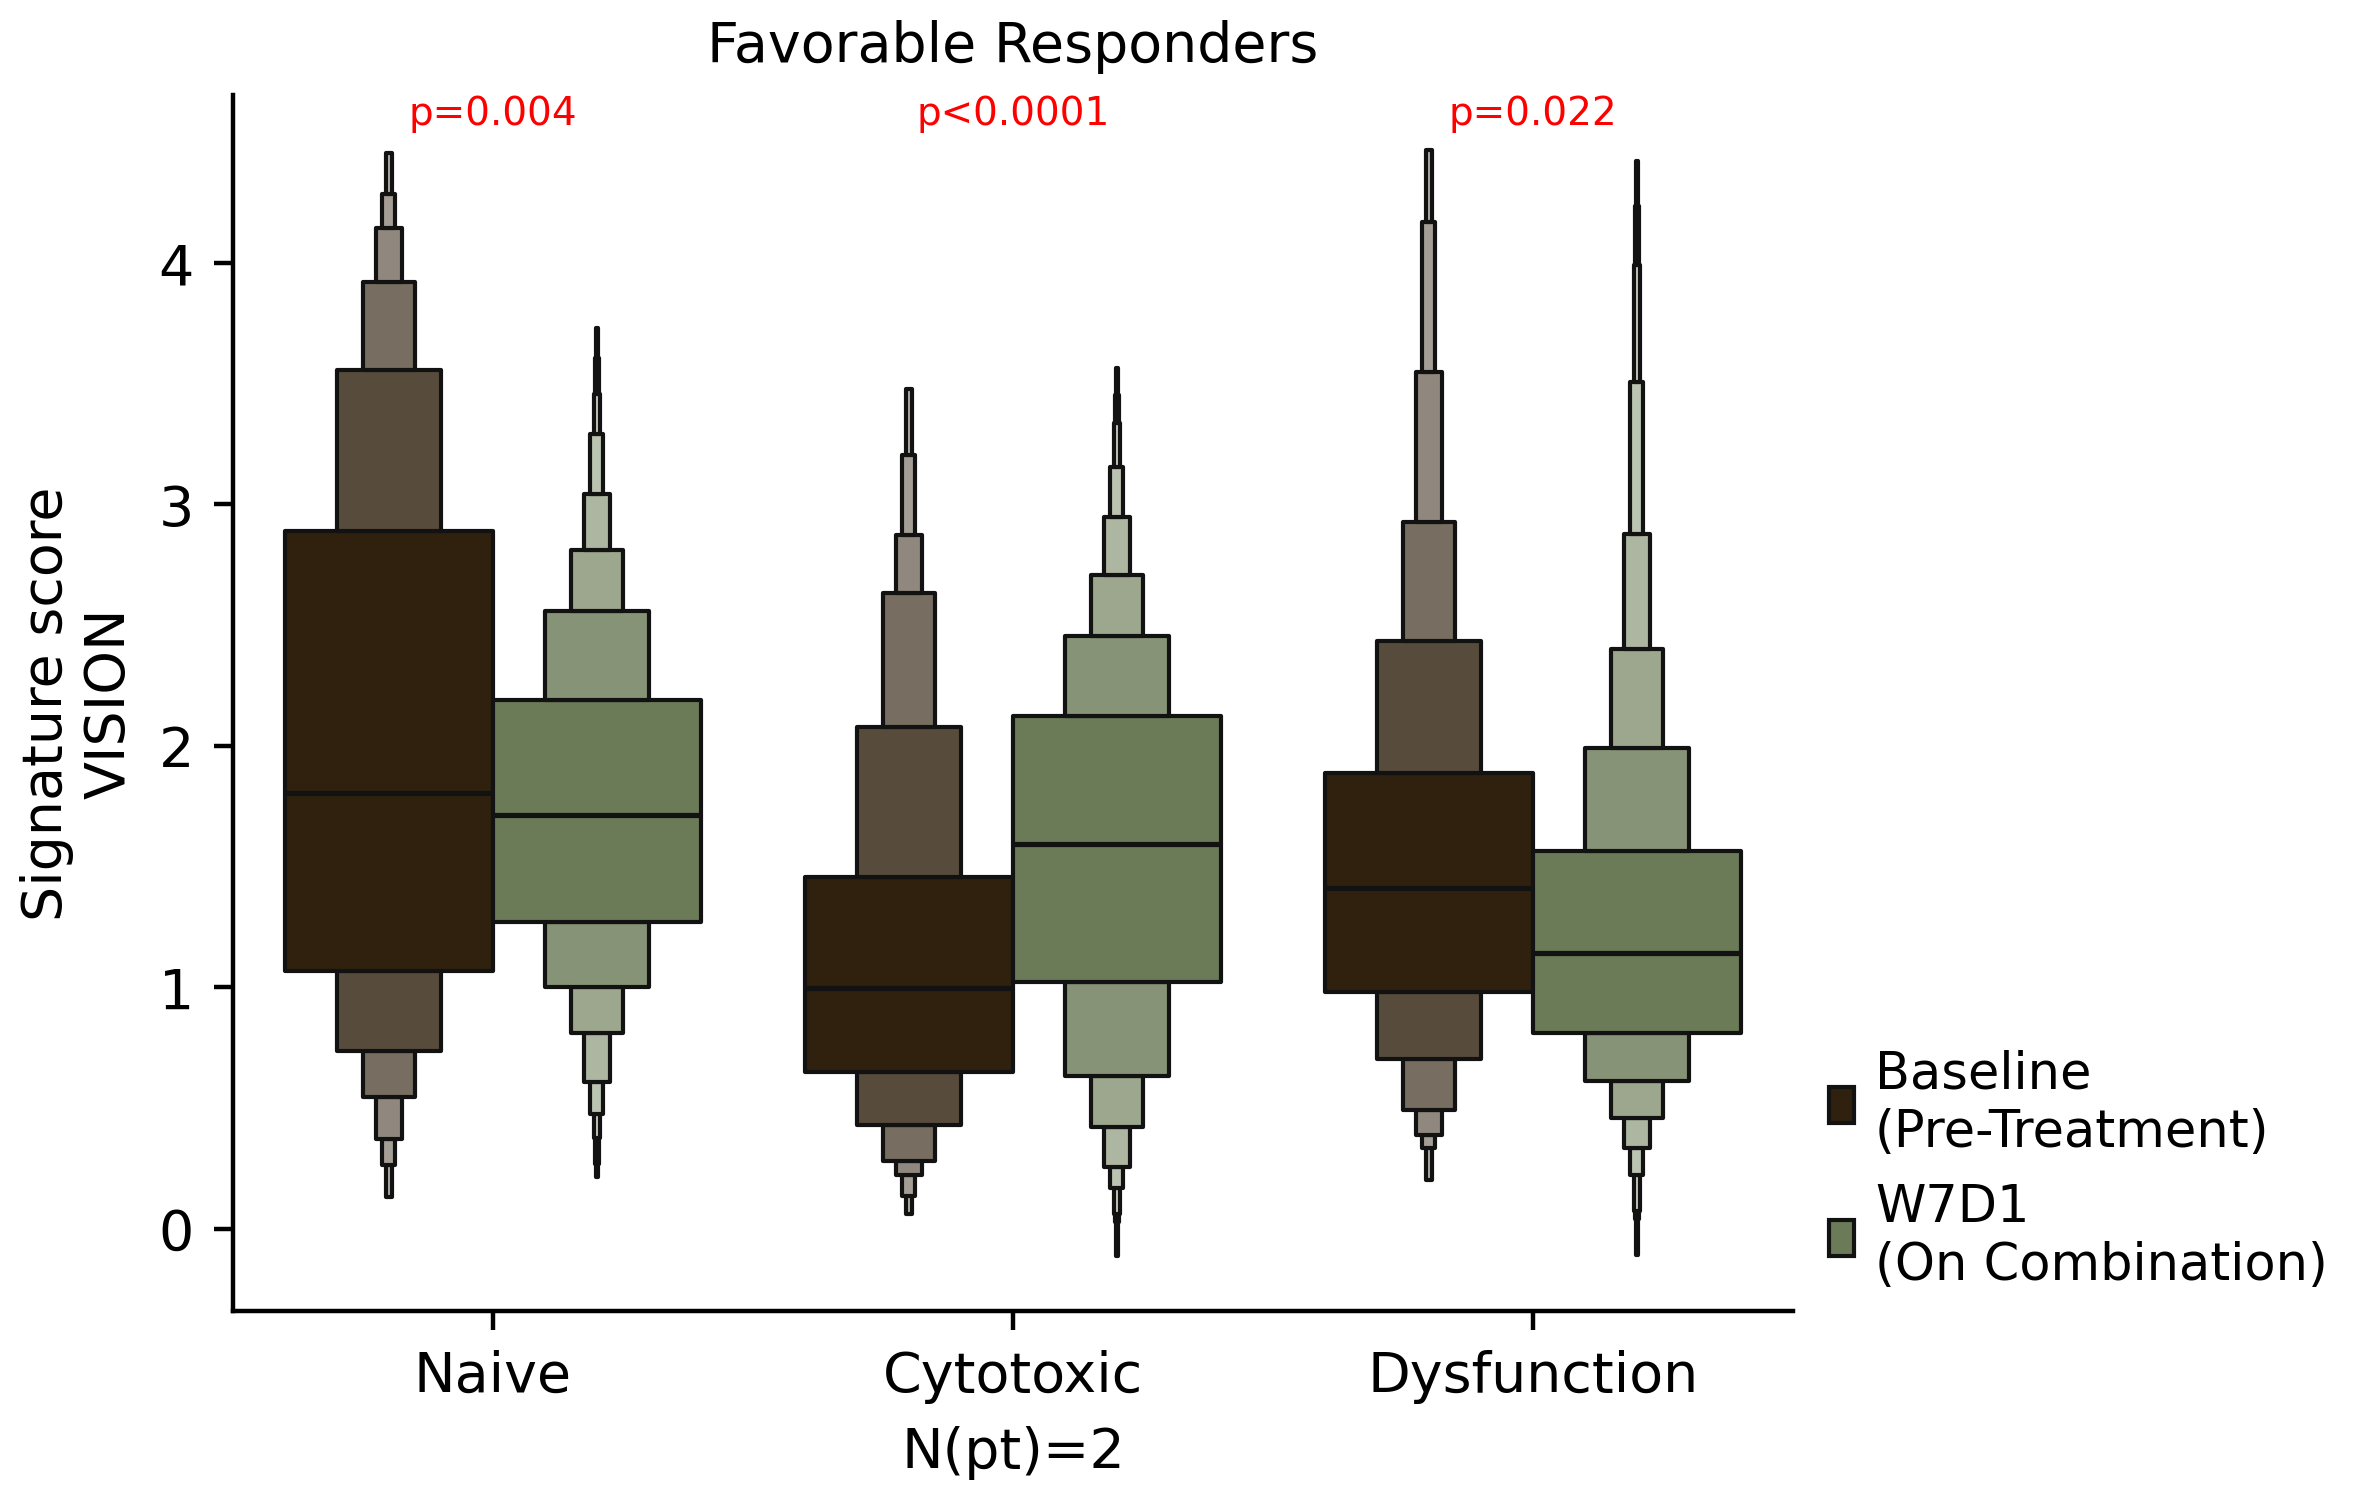

In [30]:
show_mps = ['Naive','Cytotoxic','Dysfunction']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
plot_rename = {'Baseline':'Baseline\n(Pre-Treatment)','W7D1':'W7D1\n(On Combination)'}
dt[x] = dt[x].replace(plot_rename)
palette = {}
for k,v in plot_rename.items():
    palette[v] = COLOR_PAlETTE[x][k]

fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=200)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=palette,ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.3f}" if pvalues[text] >= 0.0001 else "p<0.0001"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='Favorable Responders')
# ax.set_xticklabels([])
ax.grid(False)
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False);

# Cytokine

In [29]:
cytosig_pvalue = pd.read_csv(f'{WORKFLOW_DATA}/{GEX_Cohort}/{GEX_Cohort}/cytoSig_pvalue.csv',index_col=0)
cytosig = pd.read_csv(f'{WORKFLOW_DATA}/{GEX_Cohort}/{GEX_Cohort}/cytoSig_zscore.csv',index_col=0)
cytosig.columns = cytosig.columns.map(lambda x:x.split('.')[1]) # remove the cell type prefix
cytosig_pvalue.columns = cytosig_pvalue.columns.map(lambda x:x.split('.')[1]) # remove the cell type prefix
cytosig = cytosig[adata.obs.index.intersection(cytosig.columns)].T
cytosig_pvalue = cytosig_pvalue[adata.obs.index.intersection(cytosig_pvalue.columns)].T
cytosig[cytosig_pvalue<=0.1]=0

In [30]:
ns_cytokines = (cytosig_pvalue<0.1).mean()

In [31]:
cytosig = cytosig.loc[:,ns_cytokines > 0.2]
cytosig.columns =cytosig.columns +' Cytokine'

In [32]:
ol_bcs = cytosig.index.intersection(adata.obs.index)
del adata.uns
adata_new = adata[ol_bcs].copy()

In [33]:
for c in cytosig:
    adata_new.obs[c] = cytosig[c]

In [34]:
from statsmodels.stats.multitest import multipletests
de_cyto={}
data  = adata_new.obs[cytosig.columns.tolist()+['Cellstate','Sample_Short']].copy()
for celltype,expr in data.groupby(['Cellstate']):
    expr = expr.groupby('Sample_Short').mean().dropna(how='all',axis=0)
    ctrl = data.loc[data.index.difference(expr.index),
                       :].drop(['Cellstate'],axis=1
                              ).groupby('Sample_Short').mean().dropna(how='all',axis=0)
    stats_res = expr.apply(lambda c: pd.Series(scipy.stats.ranksums(c.values,ctrl[c.name].values),index=['Zscore','Pvalue']),axis=0).T
    stats_res['FDR'] = multipletests(stats_res['Pvalue'], method='fdr_bh')[1]
    de_cyto[celltype] = stats_res

In [35]:
de_cytokines={}
for celltype,dec in de_cyto.items():
    de_cytokines[celltype] = dec.index[(dec['Pvalue']<0.05)&
                                      (dec['Zscore']>0)].str.replace('_',' ').tolist()
de_cytokines

{'CD8T.Cytotoxic': [],
 'CD8T.Dysfunction': ['IL15 Cytokine'],
 'CD8T.Naive': ['GCSF Cytokine']}

In [36]:
uniq_cyto = pd.Series([y for x in [*de_cytokines.values()] for y in x]).value_counts()
uniq_cyto

IL15 Cytokine    1
GCSF Cytokine    1
dtype: int64

In [38]:
dt = adata_new.obs[['IL15 Cytokine','Patient','Cellstate']].groupby(['Patient','Cellstate']).mean().reset_index()
dt.head()

Patient         Cellstate  IL15 Cytokine
0     P01    CD8T.Cytotoxic      -0.218997
1     P01  CD8T.Dysfunction       0.108644
2     P01        CD8T.Naive      -0.042868
3     P03    CD8T.Cytotoxic      -0.435886
4     P03  CD8T.Dysfunction      -0.390854

[Text(0.5, 0, '')]

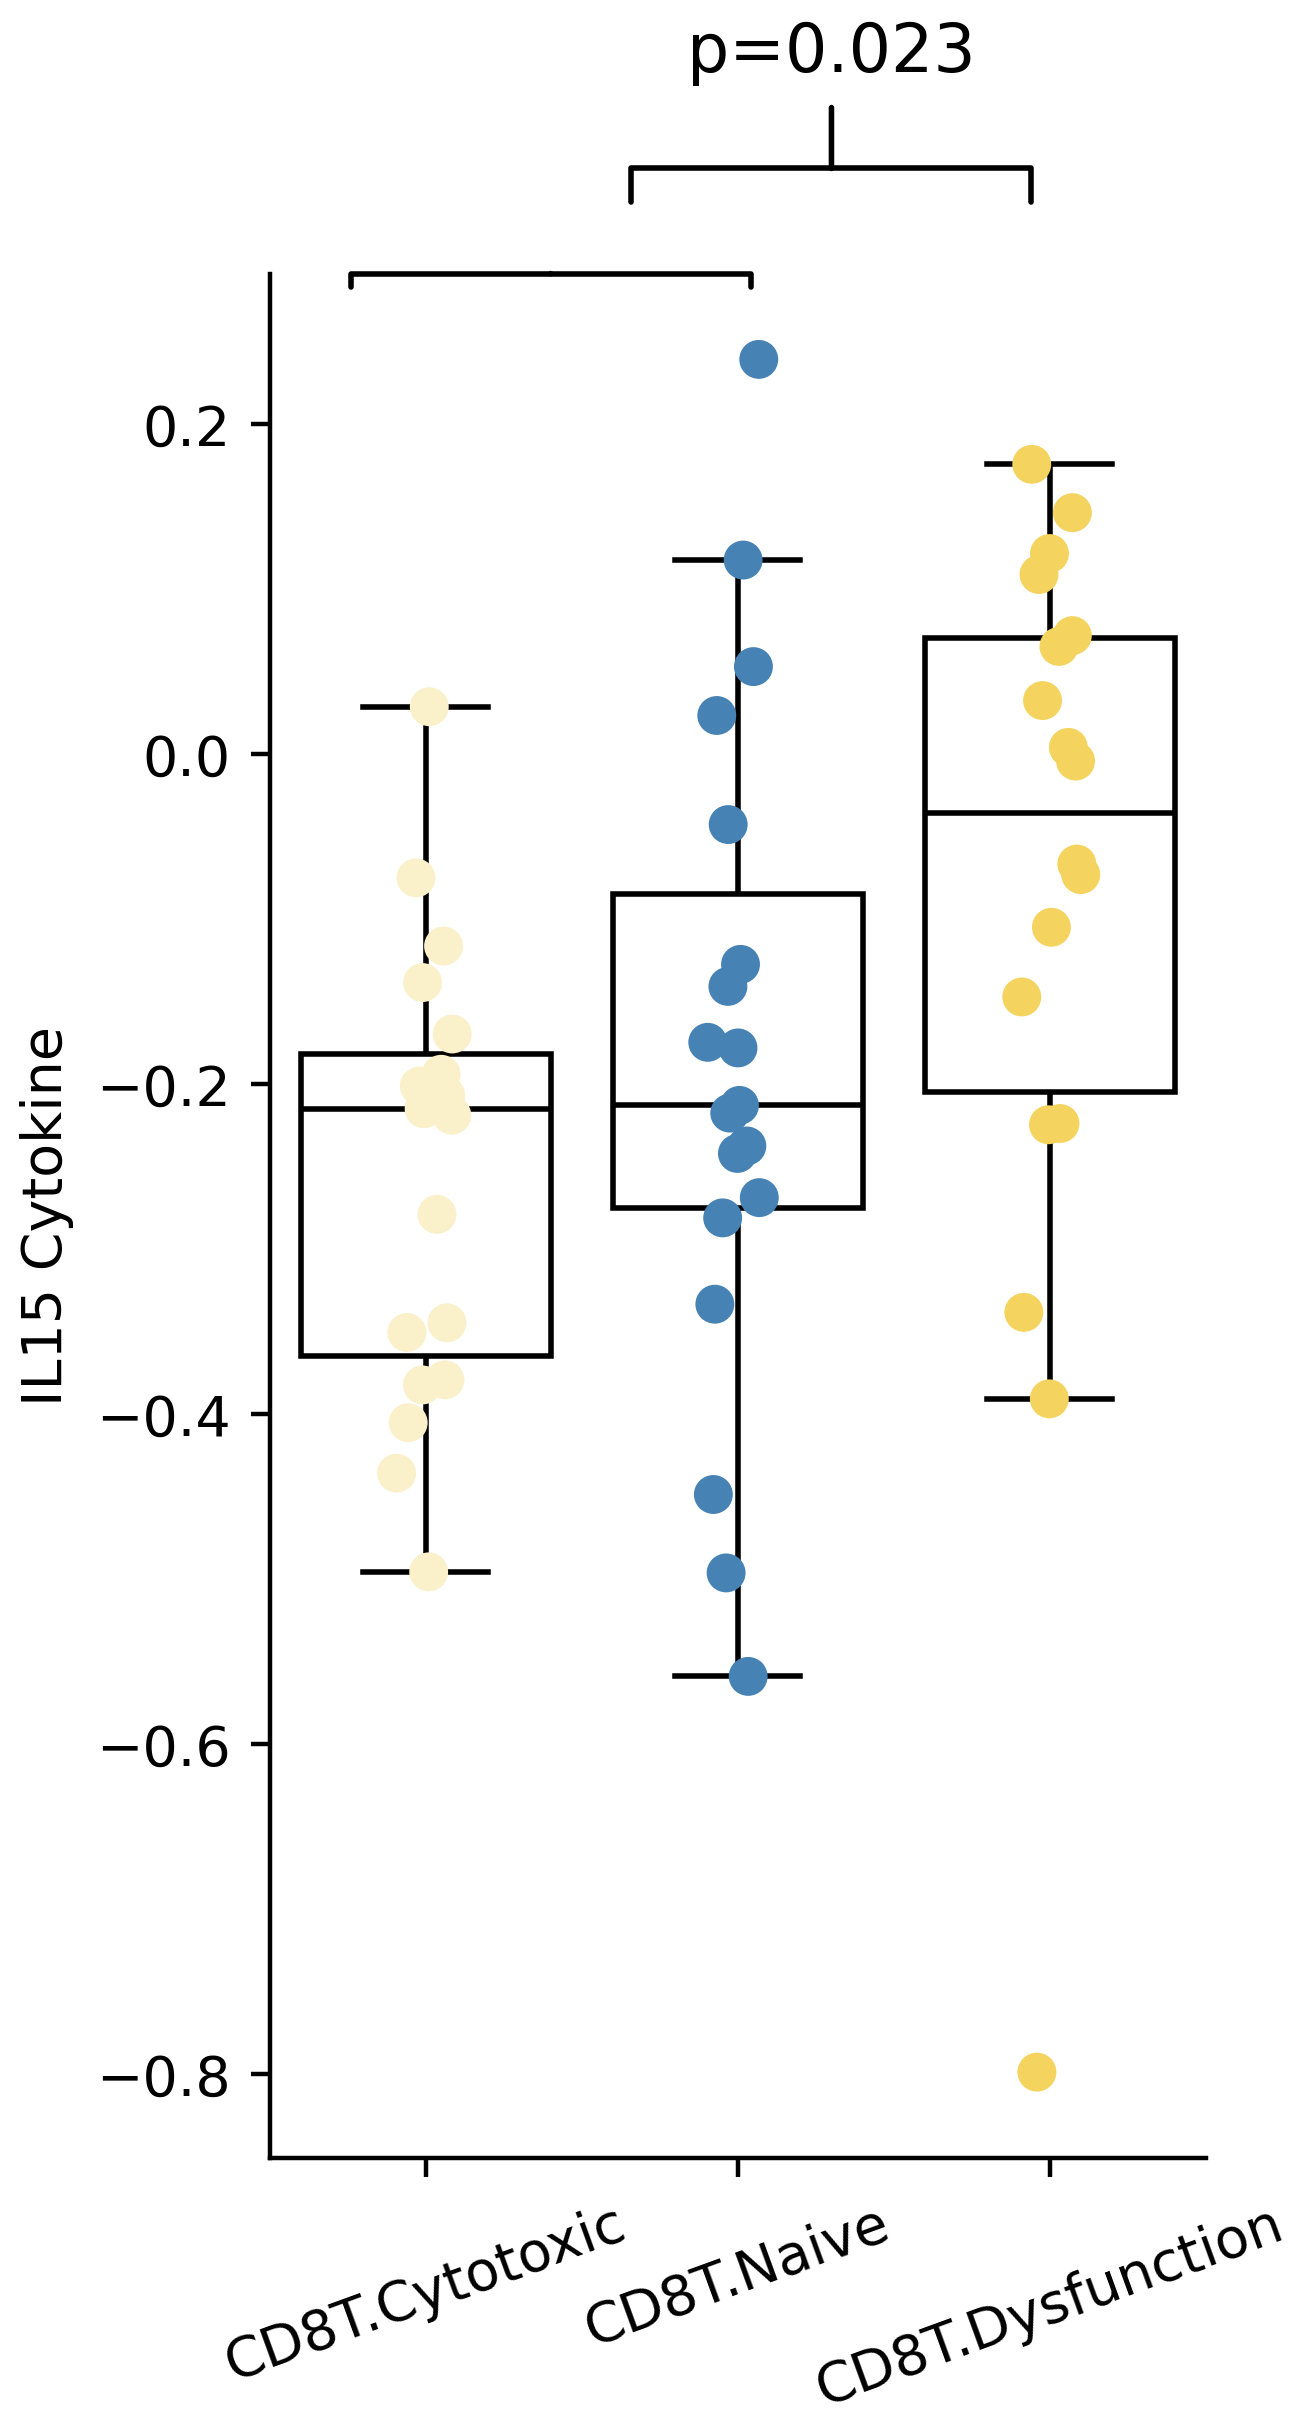

In [40]:
fig,ax=plt.subplots(1,1,figsize=(3,6),dpi=200)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.stripplot(data=dt,x='Cellstate',y='IL15 Cytokine',
              order=['CD8T.Cytotoxic','CD8T.Naive','CD8T.Dysfunction'],
              ax=ax,palette=COLOR_PAlETTE['Cellstate'],size=7)
sns.boxplot(data=dt,x='Cellstate',y='IL15 Cytokine',
            order=['CD8T.Cytotoxic','CD8T.Naive','CD8T.Dysfunction'],
            ax=ax,showfliers=False,linewidth=1,**PROPS)
ax.tick_params(axis='x',rotation=20)
pvalue = de_cyto['CD8T.Dysfunction'].loc['IL15 Cytokine','Pvalue']
ax.annotate(f"p={pvalue:.3f}", xy=(0.6, 1.05), xytext=(0.6, 1.1), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=.5', lw=1, color='k'))
ax.annotate('', xy=(0.3, 1), xytext=(0.3, 1.0001), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=.2', lw=1, color='k'))
ax.set(xlabel='')